In [2]:
import itertools
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold

import feature_selector as fs

import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_ks_statistic, plot_cumulative_gain

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
pd.set_option('display.max.columns', None)

In [4]:
appl_data = pd.read_csv('/home/yaroslav/Downloads/Telegram Desktop/test_task_data/appl_data.csv')

In [5]:
appl_data.head()

,appl_id,app_crtime,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost
0,1157589,2017-12-31T09:35:53Z,119804,1994-01-12,1,2010-10-08,4,1,3.0,5,2017-01-01,2017-01-01,8,10,NaN,3,4,NaN,NaN,7.0,2,15000.0,10000.0
1,1159012,2017-12-31T20:05:37Z,120147,1994-02-14,2,2010-04-06,4,0,0.0,5,1994-02-01,1994-02-01,9,11,2013-05-01,4,1,6.0,1.0,NaN,6,8000.0,6000.0
2,1157375,2017-12-31T08:18:56Z,119755,1984-10-20,2,2013-06-28,3,1,2.0,5,2012-05-01,2012-05-01,5,7,2015-12-01,10,1,10.0,6.0,6.0,7,15000.0,14000.0
3,1158541,2017-12-31T15:18:23Z,120042,1986-02-07,2,2012-09-27,4,0,0.0,5,1991-08-01,1991-08-01,8,10,2017-09-01,13,1,1.0,5.0,6.0,2,10000.0,5000.0
4,1157949,2017-12-31T11:25:38Z,119893,1992-06-26,2,2012-02-11,4,0,0.0,1,1992-06-01,1992-06-01,18,22,2014-08-01,3,1,10.0,5.0,3.0,1,7500.0,5000.0


In [6]:
behave_on_site = pd.read_csv('/home/yaroslav/Downloads/Telegram Desktop/test_task_data/behav_on_site.csv')

In [7]:
behave_on_site.head()

,device_id,client_id,browser,platform,create_time,id_ref
0,641468,113731,Chrome,Android,2017-12-22 16:21:57.095129+00,1366
1,755106,114439,iPhone,iPhone,2017-12-23 23:38:30.521322+00,117
2,673875,112253,Chrome,Windows,2017-12-23 12:49:34.97261+00,2727
3,755106,114439,iPhone,iPhone,2017-12-23 23:38:30.967528+00,6606
4,744303,115639,Chrome,Windows,2017-12-25 15:36:59.451907+00,3200


In [8]:
is_default = pd.read_csv('/home/yaroslav/Downloads/Telegram Desktop/test_task_data/is_default.csv')

In [9]:
is_default.head()

,appl_id,df
0,320202,good
1,320209,good
2,320226,good
3,320309,good
4,320353,good


In [10]:
is_default.df.hasnans

True

In [11]:
is_default.df.value_counts(normalize=True)

good    0.752124
bad     0.247876
Name: df, dtype: float64

In [12]:
appl_data.appl_id.nunique(), is_default.appl_id.nunique()

(8084, 8084)

In [13]:
appl_data = appl_data.merge(is_default, on='appl_id', how='right')

In [15]:
appl_data.tail()

,appl_id,app_crtime,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df
8079,320868,2017-07-01T15:21:48Z,49642,1992-11-19,2,2009-02-14,3,1,2.0,1,2009-02-10,2009-02-10,4,6,2015-04-10,3,1,2.0,1.0,NaN,6,3200.0,2000.0,good
8080,320579,2017-07-01T10:51:58Z,49587,1986-09-13,1,2008-05-22,3,1,0.0,1,2008-12-10,2008-12-10,6,8,2017-03-10,6,1,6.0,5.0,NaN,6,4000.0,2000.0,good
8081,320419,2017-07-01T08:42:59Z,49556,1989-09-26,2,2016-05-27,1,0,NaN,5,2003-04-10,2003-04-10,3,4,2011-03-10,8,1,3.0,5.0,2.0,1,7000.0,4000.0,bad
8082,321132,2017-07-01T19:43:12Z,49724,1991-12-05,2,2008-02-15,3,1,1.0,4,1994-12-10,1994-12-10,22,26,2014-12-10,5,1,8.0,6.0,7.0,1,13000.0,3500.0,good
8083,320967,2017-07-01T16:41:35Z,49681,1983-07-18,2,1999-08-04,3,2,13.0,5,2003-05-10,1983-07-10,5,13,2016-05-10,8,1,6.0,5.0,11.0,2,6000.0,4000.0,good


In [16]:
def calculate_application_features(df):
    df['monthly_income_cost_diff'] = df['monthlyincome'] - df['monthlycost']
    
    df['app_crtime'] = pd.to_datetime(df['app_crtime'])

    for col in tqdm(['birth', 'pass_bdate', 'lived_since', 'is_same_reg_lived_since', 'jobsworksince']):
        df[col] = pd.to_datetime(df[col]).apply(lambda x: x.date())

    df['qty_days_to_app_on_last_work'] = df[['jobsworksince', 'app_crtime']].apply(
        lambda x: (x['app_crtime'].date() - x['jobsworksince']).days if not pd.isna(x['app_crtime'])
        and not pd.isna(x['jobsworksince'])
        else None, axis=1)

    for suffix, dtime in tqdm(zip(['year', 'six_month', 'three_month', 'one_month'], [1, 0.5, 0.25, 0.083])):
        df['work_on_last_work_less_than_{}'.format(suffix)] = (
            (df['qty_days_to_app_on_last_work'] / 365 * dtime) < 1).astype(int)

    df['age_on_app_created'] = df[['app_crtime', 'birth']].apply(
        lambda x: (x['app_crtime'].date() - x['birth']).days // 365, axis=1)

    df['is_same_live_and_reg'] = (df['region'] == df['region_reg']).astype(int)

    df['qty_days_since_passport_given'] = df[['app_crtime', 'pass_bdate']].apply(
        lambda x: (x['app_crtime'].date() - x['pass_bdate']).days if not pd.isna(x['pass_bdate'])
        else None, axis=1)

    df['has_passport_more_than_once'] = df[['birth', 'pass_bdate']].apply(
        lambda x: ((x['pass_bdate'] - x['birth']).days // 365) > 16 if not pd.isna(x['pass_bdate'])
        else None, axis=1).fillna(False).astype(int)

    df['qty_days_to_app_on_last_live'] = df[['lived_since', 'app_crtime']].apply(
        lambda x: (x['app_crtime'].date() - x['lived_since']).days if not pd.isna(x['app_crtime'])
        and not pd.isna(x['lived_since'])
        else None, axis=1)

    for suffix, dtime in tqdm(zip(['year', 'six_month', 'three_month', 'one_month'], [1, 0.5, 0.25, 0.083])):
        df['live_on_last_live_less_than_{}'.format(suffix)] = (
            (df['qty_days_to_app_on_last_live'] / 365 * dtime) < 1).astype(int)

    df['has_adult_child'] = (df['max_age_child'] > 18).astype(int)

    df['large_family'] = (df['quantity_child'] >= 3).astype(int)
    
    df['app_created_date'] = df.app_crtime.apply(lambda time: time.date())
    df['app_create_time_weekday'] = df.app_crtime.dt.weekday
    df['app_create_time_dayofyear'] = df.app_crtime.dt.dayofyear
    df['app_create_time_month_end'] = df.app_crtime.dt.is_month_end
    df['app_create_time_month_start'] = df.app_crtime.dt.is_month_start
    df['app_create_time_quarter_start'] = df.app_crtime.dt.is_quarter_start
    df['app_create_time_quarter_end'] = df.app_crtime.dt.is_quarter_end
    
    return df

In [17]:
def calculate_aggregated_statistics(behave_df):
    result_df = pd.DataFrame()
    
    for raw_column, result_column in tqdm(zip(['id_ref', 'browser', 'platform', 'create_time_date', 'device_id'],
                                        ['qty_refs_used', 'qty_browsers_used', 'qty_platforms_used',
                                         'qty_days_of_site_activity', 'qty_devices_used'])):
        
        tmp_df = pd.DataFrame(behave_on_site.groupby('client_id')[raw_column].apply(set).apply(len)
                                    ).rename(columns={raw_column: result_column})
        
        result_df = pd.concat((result_df, tmp_df), ignore_index=False, axis=1)
    
    last_activity_data = pd.DataFrame(behave_df.groupby('client_id').create_time.max()
                                     ).rename(columns={'create_time': 'last_site_activity'})
    
    result_df = pd.concat((result_df, last_activity_data), ignore_index=False, axis=1)

    days_activity_range = pd.DataFrame(behave_df.groupby('client_id'
                                                        ).create_time_date.agg({min, max}
                                                                              ).diff(axis=1).iloc[:, 1].apply(
        lambda x: x.days)).rename(columns={'max': 'qty_days_passed_from_behaviour_starts'}
                                 )
    
    result_df = pd.concat((result_df, days_activity_range), ignore_index=False, axis=1)
    
    return result_df.reset_index(drop=False)

In [18]:
def calculate_behaviour_features(behave_df):
    behaviour_features_list = ['last_site_activity', 'qty_refs_used', 'qty_browsers_used',
       'qty_platforms_used', 'qty_days_of_site_activity', 'qty_devices_used',
       'qty_days_passed_from_behaviour_starts']
    
    behave_df.create_time = pd.to_datetime(behave_df.create_time)
    behave_df['create_time_date'] = behave_df.create_time.apply(lambda time: time.date())
    
    aggregated_behaviour_stats = calculate_aggregated_statistics(behave_df)
    
    behave_df = pd.merge(behave_df, aggregated_behaviour_stats, on='client_id')
    
    return behave_df.drop_duplicates('client_id', keep='first')[['client_id'] + behaviour_features_list]

In [19]:
appl_data = calculate_application_features(appl_data)

100%|██████████| 5/5 [00:00<00:00, 31.33it/s]
4it [00:00, 770.37it/s]
4it [00:00, 699.49it/s]


In [20]:
behave_on_site_aggregated = calculate_behaviour_features(behave_on_site)

5it [00:03,  1.44it/s]


In [21]:
behave_on_site_aggregated.head()

,client_id,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts
0,113731,2017-12-22 16:58:32.076247+00:00,3,1,1,1,1,0
13,114439,2017-12-24 03:58:46.383254+00:00,8,1,1,2,1,1
64,112253,2017-12-23 13:01:17.752318+00:00,7,1,1,3,1,3
95,115639,2017-12-25 15:41:40.751572+00:00,4,1,1,1,1,0
106,112922,2017-12-26 10:15:06.589977+00:00,8,1,1,3,1,5


In [22]:
appl_data.head()

,appl_id,app_crtime,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df,monthly_income_cost_diff,qty_days_to_app_on_last_work,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,age_on_app_created,is_same_live_and_reg,qty_days_since_passport_given,has_passport_more_than_once,qty_days_to_app_on_last_live,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,app_created_date,app_create_time_weekday,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_start,app_create_time_quarter_end
0,1157589,2017-12-31 09:35:53+00:00,119804,1994-01-12,1,2010-10-08,4,1,3.0,5,2017-01-01,2017-01-01,8,10,NaT,3,4,NaN,NaN,7.0,2,15000.0,10000.0,NaN,5000.0,NaN,0,0,0,0,23,0,2641.0,0,364,1,1,1,1,0,0,2017-12-31,6,365,True,False,False,True
1,1159012,2017-12-31 20:05:37+00:00,120147,1994-02-14,2,2010-04-06,4,0,0.0,5,1994-02-01,1994-02-01,9,11,2013-05-01,4,1,6.0,1.0,NaN,6,8000.0,6000.0,NaN,2000.0,1705.0,0,0,0,1,23,0,2826.0,0,8734,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True
2,1157375,2017-12-31 08:18:56+00:00,119755,1984-10-20,2,2013-06-28,3,1,2.0,5,2012-05-01,2012-05-01,5,7,2015-12-01,10,1,10.0,6.0,6.0,7,15000.0,14000.0,NaN,1000.0,761.0,0,0,1,1,33,0,1647.0,1,2070,0,0,0,1,0,0,2017-12-31,6,365,True,False,False,True
3,1158541,2017-12-31 15:18:23+00:00,120042,1986-02-07,2,2012-09-27,4,0,0.0,5,1991-08-01,1991-08-01,8,10,2017-09-01,13,1,1.0,5.0,6.0,2,10000.0,5000.0,NaN,5000.0,121.0,1,1,1,1,31,0,1921.0,1,9649,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True
4,1157949,2017-12-31 11:25:38+00:00,119893,1992-06-26,2,2012-02-11,4,0,0.0,1,1992-06-01,1992-06-01,18,22,2014-08-01,3,1,10.0,5.0,3.0,1,7500.0,5000.0,NaN,2500.0,1248.0,0,0,1,1,25,0,2150.0,1,9344,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True


In [23]:
behave_on_site_aggregated = pd.merge(appl_data[['appl_id', 'app_crtime', 'client_id']],
                                    behave_on_site_aggregated, on='client_id')

# Use both application and behaviour data

In [24]:
all_data = pd.merge(appl_data.drop(['appl_id', 'app_crtime'], axis=1), behave_on_site_aggregated, on='client_id')

In [25]:
all_data.head()

,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df,monthly_income_cost_diff,qty_days_to_app_on_last_work,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,age_on_app_created,is_same_live_and_reg,qty_days_since_passport_given,has_passport_more_than_once,qty_days_to_app_on_last_live,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,app_created_date,app_create_time_weekday,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_start,app_create_time_quarter_end,appl_id,app_crtime,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts
0,119804,1994-01-12,1,2010-10-08,4,1,3.0,5,2017-01-01,2017-01-01,8,10,NaT,3,4,NaN,NaN,7.0,2,15000.0,10000.0,NaN,5000.0,NaN,0,0,0,0,23,0,2641.0,0,364,1,1,1,1,0,0,2017-12-31,6,365,True,False,False,True,1157589,2017-12-31 09:35:53+00:00,2017-12-31 09:35:39.153545+00:00,3,1,1,1,1,0
1,120147,1994-02-14,2,2010-04-06,4,0,0.0,5,1994-02-01,1994-02-01,9,11,2013-05-01,4,1,6.0,1.0,NaN,6,8000.0,6000.0,NaN,2000.0,1705.0,0,0,0,1,23,0,2826.0,0,8734,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True,1159012,2017-12-31 20:05:37+00:00,2017-12-31 20:05:09.351273+00:00,4,1,1,1,1,0
2,119755,1984-10-20,2,2013-06-28,3,1,2.0,5,2012-05-01,2012-05-01,5,7,2015-12-01,10,1,10.0,6.0,6.0,7,15000.0,14000.0,NaN,1000.0,761.0,0,0,1,1,33,0,1647.0,1,2070,0,0,0,1,0,0,2017-12-31,6,365,True,False,False,True,1157375,2017-12-31 08:18:56+00:00,2017-12-31 08:18:43.603247+00:00,3,1,1,1,1,0
3,120042,1986-02-07,2,2012-09-27,4,0,0.0,5,1991-08-01,1991-08-01,8,10,2017-09-01,13,1,1.0,5.0,6.0,2,10000.0,5000.0,NaN,5000.0,121.0,1,1,1,1,31,0,1921.0,1,9649,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True,1158541,2017-12-31 15:18:23+00:00,2017-12-31 15:18:12.687655+00:00,3,1,1,1,1,0
4,119893,1992-06-26,2,2012-02-11,4,0,0.0,1,1992-06-01,1992-06-01,18,22,2014-08-01,3,1,10.0,5.0,3.0,1,7500.0,5000.0,NaN,2500.0,1248.0,0,0,1,1,25,0,2150.0,1,9344,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True,1157949,2017-12-31 11:25:38+00:00,2017-12-31 11:25:25.621322+00:00,3,1,1,1,1,0


In [26]:
test_data = all_data[all_data.df.isnull()]

In [27]:
test_data.head()

,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df,monthly_income_cost_diff,qty_days_to_app_on_last_work,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,age_on_app_created,is_same_live_and_reg,qty_days_since_passport_given,has_passport_more_than_once,qty_days_to_app_on_last_live,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,app_created_date,app_create_time_weekday,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_start,app_create_time_quarter_end,appl_id,app_crtime,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts
0,119804,1994-01-12,1,2010-10-08,4,1,3.0,5,2017-01-01,2017-01-01,8,10,NaT,3,4,NaN,NaN,7.0,2,15000.0,10000.0,NaN,5000.0,NaN,0,0,0,0,23,0,2641.0,0,364,1,1,1,1,0,0,2017-12-31,6,365,True,False,False,True,1157589,2017-12-31 09:35:53+00:00,2017-12-31 09:35:39.153545+00:00,3,1,1,1,1,0
1,120147,1994-02-14,2,2010-04-06,4,0,0.0,5,1994-02-01,1994-02-01,9,11,2013-05-01,4,1,6.0,1.0,NaN,6,8000.0,6000.0,NaN,2000.0,1705.0,0,0,0,1,23,0,2826.0,0,8734,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True,1159012,2017-12-31 20:05:37+00:00,2017-12-31 20:05:09.351273+00:00,4,1,1,1,1,0
2,119755,1984-10-20,2,2013-06-28,3,1,2.0,5,2012-05-01,2012-05-01,5,7,2015-12-01,10,1,10.0,6.0,6.0,7,15000.0,14000.0,NaN,1000.0,761.0,0,0,1,1,33,0,1647.0,1,2070,0,0,0,1,0,0,2017-12-31,6,365,True,False,False,True,1157375,2017-12-31 08:18:56+00:00,2017-12-31 08:18:43.603247+00:00,3,1,1,1,1,0
3,120042,1986-02-07,2,2012-09-27,4,0,0.0,5,1991-08-01,1991-08-01,8,10,2017-09-01,13,1,1.0,5.0,6.0,2,10000.0,5000.0,NaN,5000.0,121.0,1,1,1,1,31,0,1921.0,1,9649,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True,1158541,2017-12-31 15:18:23+00:00,2017-12-31 15:18:12.687655+00:00,3,1,1,1,1,0
4,119893,1992-06-26,2,2012-02-11,4,0,0.0,1,1992-06-01,1992-06-01,18,22,2014-08-01,3,1,10.0,5.0,3.0,1,7500.0,5000.0,NaN,2500.0,1248.0,0,0,1,1,25,0,2150.0,1,9344,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True,1157949,2017-12-31 11:25:38+00:00,2017-12-31 11:25:25.621322+00:00,3,1,1,1,1,0


In [28]:
train_data = all_data[~all_data.df.isnull()]

In [29]:
train_data.head()

,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df,monthly_income_cost_diff,qty_days_to_app_on_last_work,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,age_on_app_created,is_same_live_and_reg,qty_days_since_passport_given,has_passport_more_than_once,qty_days_to_app_on_last_live,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,app_created_date,app_create_time_weekday,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_start,app_create_time_quarter_end,appl_id,app_crtime,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts
3997,87198,1990-05-28,1,2006-09-12,4,0,NaN,5,2017-07-01,2017-07-01,18,22,2015-08-01,5,1,13.0,1.0,NaN,6,6500.0,4000.0,bad,2500.0,822.0,0,0,1,1,27,0,4067.0,0,122,1,1,1,1,0,0,2017-10-31,1,304,True,False,False,False,762157,2017-10-31 16:01:01+00:00,2017-10-31 16:00:52.677855+00:00,3,1,1,1,1,0
4042,50111,1993-03-07,1,2013-04-05,3,2,4.0,1,2015-09-10,2015-09-10,1,2,2015-03-01,2,3,12.0,6.0,NaN,6,6000.0,1500.0,bad,4500.0,975.0,0,0,1,1,24,0,1670.0,1,782,0,0,1,1,0,0,2017-10-31,1,304,True,False,False,False,761384,2017-10-31 11:12:33+00:00,2017-10-31 11:11:51.842310+00:00,19,2,2,5,1,120
4043,78479,1991-01-06,2,2007-08-08,4,0,NaN,5,2017-02-01,1992-12-01,6,8,2017-02-01,8,1,6.0,5.0,11.0,2,7000.0,3000.0,bad,4000.0,272.0,1,1,1,1,26,0,3737.0,0,272,1,1,1,1,0,0,2017-10-31,1,304,True,False,False,False,762215,2017-10-31 16:20:42+00:00,2017-10-31 16:20:15.661290+00:00,7,1,1,3,1,24
4071,87254,1993-03-30,1,2011-05-04,1,0,NaN,1,2016-05-01,1993-03-01,3,8,2016-05-01,5,1,12.0,6.0,NaN,6,9500.0,2500.0,good,7000.0,548.0,0,1,1,1,24,0,2372.0,1,548,0,1,1,1,0,0,2017-10-31,1,304,True,False,False,False,762424,2017-10-31 18:01:52+00:00,2017-10-31 18:01:42.708911+00:00,4,1,1,1,1,0
4086,87108,1995-04-18,1,2012-05-16,4,0,NaN,5,1995-04-01,1995-04-01,18,22,2016-11-01,3,1,12.0,5.0,10.0,2,7500.0,4500.0,good,3000.0,364.0,1,1,1,1,22,0,1994.0,1,8249,0,0,0,0,0,0,2017-10-31,1,304,True,False,False,False,761818,2017-10-31 13:47:08+00:00,2017-10-31 13:46:54.552017+00:00,4,1,1,1,1,0


In [30]:
train_data.df.hasnans

False

In [31]:
train_data.df.value_counts(normalize=True)

good    0.752124
bad     0.247876
Name: df, dtype: float64

In [32]:
categorical_features = ['gender', 'fam_status', 'property', 'region', 'region_reg', 'empl_state', 'empl_type',
       'empl_worker_count', 'education_area', 'education', 'work_on_last_work_less_than_year',
       'work_on_last_work_less_than_six_month','work_on_last_work_less_than_three_month',
       'work_on_last_work_less_than_one_month', 'is_same_live_and_reg', 'live_on_last_live_less_than_year',
       'live_on_last_live_less_than_six_month','live_on_last_live_less_than_three_month',
       'live_on_last_live_less_than_one_month', 'has_adult_child','large_family','has_passport_more_than_once',
        'app_create_time_dayofyear','app_create_time_month_end','app_create_time_month_start',
        'app_create_time_quarter_end','app_create_time_quarter_start','app_create_time_weekday']

numeric_features = ['max_age_child', 'work_experience', 'monthly_income_cost_diff',
                    'qty_days_to_app_on_last_work', 'age_on_app_created', 'qty_days_since_passport_given',
                   'qty_days_to_app_on_last_live', 'qty_browsers_used','qty_days_of_site_activity',
                    'qty_days_passed_from_behaviour_starts','qty_devices_used','qty_platforms_used',
                    'qty_refs_used', 'quantity_child']

In [33]:
def prepare_dataset(df, cat_features, numeric_features, target='df', fill_cat='other', fill_num=-1,
                    encoder=TargetEncoder, transformer=MinMaxScaler):
    
    used_encoder = encoder(cols=cat_features)
    used_transformer = transformer()
    
    replace_mapping = {'bad': 1, 'good': 0}
    
    try:
        df[target] = df[target].replace(replace_mapping)
    except TypeError:
        print('Already replaced')
    
    if cat_features:
        df[cat_features] = df[cat_features].fillna(fill_cat)

        encoded_feats = list(map(lambda x: x+'_encoded', cat_features))

        df[encoded_feats] = used_encoder.fit_transform(df[cat_features], df[target])
    else:
        used_encoder = None
        encoded_feats = []
    
    if numeric_features:
        df[numeric_features] = df[numeric_features].fillna(fill_num)

        df[numeric_features] = used_transformer.fit_transform(df[numeric_features])
    else:
        used_transformer = None
    
    all_features = cat_features + numeric_features
    all_features_encoded = encoded_feats + numeric_features
    
    prepared_data = df[['appl_id', 'app_crtime', target] + all_features]
    prepared_data_encoded = df[['appl_id', 'app_crtime', target] + all_features_encoded]
    
    prepared_data['app_crtime_date'] = pd.to_datetime(prepared_data['app_crtime']).apply(lambda x: x.date())
    prepared_data_encoded['app_crtime_date'] = pd.to_datetime(prepared_data_encoded['app_crtime']).apply(lambda x: x.date())

    return prepared_data, prepared_data_encoded, used_encoder, used_transformer, all_features, all_features_encoded

In [34]:
train_data['df'].hasnans

False

In [35]:
prepared_data, prepared_data_encoded, fitted_encoder, fitted_transformer, all_features, all_features_encoded = prepare_dataset(
    train_data, categorical_features, numeric_features)

In [36]:
prepared_data.head()

,appl_id,app_crtime,df,gender,fam_status,property,region,region_reg,empl_state,empl_type,empl_worker_count,education_area,education,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,is_same_live_and_reg,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,has_passport_more_than_once,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_end,app_create_time_quarter_start,app_create_time_weekday,max_age_child,work_experience,monthly_income_cost_diff,qty_days_to_app_on_last_work,age_on_app_created,qty_days_since_passport_given,qty_days_to_app_on_last_live,qty_browsers_used,qty_days_of_site_activity,qty_days_passed_from_behaviour_starts,qty_devices_used,qty_platforms_used,qty_refs_used,quantity_child,app_crtime_date
3997,762157,2017-10-31 16:01:01+00:00,1,1,4,5,18,22,1,13,1,other,6,0,0,1,1,0,1,1,1,1,0,0,0,304,True,False,False,False,1,0.000000,0.044643,0.490,0.047382,0.157895,0.297430,0.006604,0.000000,0.000000,0.000000,0.0,0.0,0.058824,0.000000,2017-10-31
4042,761384,2017-10-31 11:12:33+00:00,1,1,3,1,1,2,3,12,6,other,6,0,0,1,1,0,0,0,1,1,0,0,1,304,True,False,False,False,1,0.104167,0.017857,0.498,0.056137,0.105263,0.128687,0.041199,0.333333,0.129032,0.833333,0.0,0.5,0.529412,0.166667,2017-10-31
4043,762215,2017-10-31 16:20:42+00:00,1,2,4,5,6,8,1,6,5,11,2,1,1,1,1,0,1,1,1,1,0,0,0,304,True,False,False,False,1,0.000000,0.071429,0.496,0.015908,0.140351,0.274199,0.014467,0.000000,0.064516,0.166667,0.0,0.0,0.176471,0.000000,2017-10-31
4071,762424,2017-10-31 18:01:52+00:00,0,1,1,1,3,8,1,12,6,other,6,0,1,1,1,0,0,1,1,1,0,0,1,304,True,False,False,False,1,0.000000,0.044643,0.508,0.031702,0.105263,0.178106,0.028934,0.000000,0.000000,0.000000,0.0,0.0,0.088235,0.000000,2017-10-31
4086,761818,2017-10-31 13:47:08+00:00,0,1,4,5,18,22,1,12,5,10,2,1,1,1,1,0,0,0,0,0,0,0,1,304,True,False,False,False,1,0.000000,0.026786,0.492,0.021173,0.070175,0.151496,0.432593,0.000000,0.000000,0.000000,0.0,0.0,0.088235,0.000000,2017-10-31


In [37]:
#compute class weights for binary classification
cw = list(class_weight.compute_class_weight('balanced', prepared_data['df'].unique(), prepared_data['df']))

In [38]:
cw

[2.0171370967741935, 0.6647840531561462]

In [39]:
def get_splits_on_date(df, n_train, date_column='app_crtime_date'):
    """Calculates dataframe splits on train and test samples, based on date: 
        more older objects will be used for train, more fresh - for test"""
    
    """:param df - dataframe to split
       :param n_train - qty date points for train
       :param date_column - column in df that specifies date to split
       
       :returns tuple with dates for train, test and validate samples"""
    
    unique_dates = df.sort_values(date_column)[date_column].unique()

    train_dates = []
    test_dates = []
    for index in range(len(unique_dates) - n_train):
        train = unique_dates[index:index + n_train]
        test = [unique_dates[index + n_train]]

        train_dates.append(train)
        test_dates.append(test)
    
    return train_dates, test_dates

In [40]:
def split_dates(df, date_column='app_crtime_date', train_frac=0.8):
    """Splits dates of dataframe into train, test and validate"""
    
    """:param df - dataframe to split
       :param date_column - column in df that specifies date to split
       :param train_frac - fraction of data that must be used for train
       
       :returns splitted dates for train, test and validate"""

    n_train = int(df[date_column].nunique() * train_frac)
    tr, tst = get_splits_on_date(df, date_column=date_column, n_train=n_train)
    train = np.unique(sorted(list(itertools.chain(*tr))))
    test = np.unique(tst)
    train = np.array([el for el in train if el not in test])

    return train, test


def train_test_split(df, date_column='app_crtime_date'):
    """Splits dataframe into train, validate and test based on date"""
    
    """:param df - dataframe to split
       :param date_column - column in df that specifies date to split
       
       :returns tuple with train, validate and test parts of given dataframe"""
    
    train, test = split_dates(df, date_column)
    train_df = df[df[date_column].isin(train)]
    test_df = df[df[date_column].isin(test)]

    return train_df, test_df

In [41]:
train_prepared, test_prepared = train_test_split(prepared_data)

In [42]:
train_prepared.head(2)

,appl_id,app_crtime,df,gender,fam_status,property,region,region_reg,empl_state,empl_type,empl_worker_count,education_area,education,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,is_same_live_and_reg,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,has_passport_more_than_once,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_end,app_create_time_quarter_start,app_create_time_weekday,max_age_child,work_experience,monthly_income_cost_diff,qty_days_to_app_on_last_work,age_on_app_created,qty_days_since_passport_given,qty_days_to_app_on_last_live,qty_browsers_used,qty_days_of_site_activity,qty_days_passed_from_behaviour_starts,qty_devices_used,qty_platforms_used,qty_refs_used,quantity_child,app_crtime_date
5284,648967,2017-10-06 22:59:35+00:00,0,2,4,1,16,20,1,2,1,other,6,0,0,1,1,0,0,0,0,0,0,0,0,279,False,False,False,False,4,0.0,0.035714,0.4888,0.049442,0.210526,0.372122,0.582870,0.0,0.0,0.0,0.0,0.0,0.323529,0.0,2017-10-06
5298,648906,2017-10-06 21:37:55+00:00,0,2,4,5,3,4,3,7,6,11,1,0,0,1,1,0,0,0,0,0,0,0,1,279,False,False,False,False,4,0.0,0.053571,0.4980,0.070329,0.157895,0.128124,0.407328,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,2017-10-06


In [43]:
test_prepared.head(2)

,appl_id,app_crtime,df,gender,fam_status,property,region,region_reg,empl_state,empl_type,empl_worker_count,education_area,education,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,is_same_live_and_reg,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,has_passport_more_than_once,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_end,app_create_time_quarter_start,app_create_time_weekday,max_age_child,work_experience,monthly_income_cost_diff,qty_days_to_app_on_last_work,age_on_app_created,qty_days_since_passport_given,qty_days_to_app_on_last_live,qty_browsers_used,qty_days_of_site_activity,qty_days_passed_from_behaviour_starts,qty_devices_used,qty_platforms_used,qty_refs_used,quantity_child,app_crtime_date
3997,762157,2017-10-31 16:01:01+00:00,1,1,4,5,18,22,1,13,1,other,6,0,0,1,1,0,1,1,1,1,0,0,0,304,True,False,False,False,1,0.000000,0.044643,0.490,0.047382,0.157895,0.297430,0.006604,0.000000,0.000000,0.000000,0.0,0.0,0.058824,0.000000,2017-10-31
4042,761384,2017-10-31 11:12:33+00:00,1,1,3,1,1,2,3,12,6,other,6,0,0,1,1,0,0,0,1,1,0,0,1,304,True,False,False,False,1,0.104167,0.017857,0.498,0.056137,0.105263,0.128687,0.041199,0.333333,0.129032,0.833333,0.0,0.5,0.529412,0.166667,2017-10-31


In [44]:
train_prepared.app_crtime_date.agg({min, max})

min    2017-07-01
max    2017-10-06
Name: app_crtime_date, dtype: object

In [45]:
test_prepared.app_crtime_date.agg({min, max})

min    2017-10-07
max    2017-10-31
Name: app_crtime_date, dtype: object

In [46]:
train_prepared_encoded, test_prepared_encoded = train_test_split(prepared_data_encoded)

In [47]:
train_prepared[categorical_features] = train_prepared[categorical_features].astype(str)
test_prepared[categorical_features] = test_prepared[categorical_features].astype(str)

In [48]:
def calculate_metrics(test_df, proba_column, target, cutoff=None):
    if cutoff:
        test_df['{}_predict'.format(proba_column)] = (test_df[proba_column] > cutoff).astype(int)
    else:
        test_df['{}_predict'.format(proba_column)] = (test_df[proba_column] > 0.5).astype(int)
    
    metrics_mapping = {}
    for metric, title in zip([roc_auc_score, f1_score], ['AUC', 'F1']):
        metric_value = metric(test_df[target],test_df['{}_predict'.format(proba_column)])
        
        print('{metric}: {value}'.format(metric=title,
                                         value=metric_value
                                        ))
        metrics_mapping[title] = metric_value
    gini = 2 * metrics_mapping.get('AUC') - 1
    
    print('Gini: {}'.format(gini))

## No encodings

### Catboost

In [49]:
ctb = CatBoostClassifier(n_estimators=500, learning_rate=0.03, max_depth=3, random_state=42,
                         loss_function='Logloss', cat_features=categorical_features,
                         min_data_in_leaf=100, verbose=2, class_weights=cw,
                        custom_metric=['AUC', 'F1'])

In [50]:
ctb.fit(
    train_prepared[all_features], train_prepared['df'],
    eval_set=(test_prepared[all_features], test_prepared['df']),
    verbose=2,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6663147	test: 0.6670087	best: 0.6670087 (0)	total: 52.4ms	remaining: 26.1s
2:	learn: 0.6180944	test: 0.6201974	best: 0.6201974 (2)	total: 61.2ms	remaining: 10.1s
4:	learn: 0.5765045	test: 0.5798599	best: 0.5798599 (4)	total: 71.7ms	remaining: 7.1s
6:	learn: 0.5407035	test: 0.5452472	best: 0.5452472 (6)	total: 78.2ms	remaining: 5.51s
8:	learn: 0.5099424	test: 0.5156347	best: 0.5156347 (8)	total: 84.6ms	remaining: 4.62s
10:	learn: 0.4834459	test: 0.4902158	best: 0.4902158 (10)	total: 91ms	remaining: 4.04s
12:	learn: 0.4606269	test: 0.4683762	best: 0.4683762 (12)	total: 99ms	remaining: 3.71s
14:	learn: 0.4410164	test: 0.4496490	best: 0.4496490 (14)	total: 106ms	remaining: 3.42s
16:	learn: 0.4240386	test: 0.4335118	best: 0.4335118 (16)	total: 115ms	remaining: 3.27s
18:	learn: 0.4093623	test: 0.4196599	best: 0.4196599 (18)	total: 124ms	remaining: 3.14s
20:	learn: 0.3967041	test: 0.4077641	best: 0.4077641 (20)	total: 132ms	remaining: 3.01s
22:	learn: 0.3857451	test: 0.3977512	bes

188:	learn: 0.3055765	test: 0.3333999	best: 0.3333947 (185)	total: 870ms	remaining: 1.43s
190:	learn: 0.3054780	test: 0.3333825	best: 0.3333803 (189)	total: 880ms	remaining: 1.42s
192:	learn: 0.3054220	test: 0.3333623	best: 0.3333623 (192)	total: 888ms	remaining: 1.41s
194:	learn: 0.3053798	test: 0.3333815	best: 0.3333623 (192)	total: 899ms	remaining: 1.41s
196:	learn: 0.3052631	test: 0.3333284	best: 0.3333284 (196)	total: 909ms	remaining: 1.4s
198:	learn: 0.3051830	test: 0.3333330	best: 0.3333284 (196)	total: 921ms	remaining: 1.39s
200:	learn: 0.3050989	test: 0.3332624	best: 0.3332617 (199)	total: 944ms	remaining: 1.4s
202:	learn: 0.3050439	test: 0.3331884	best: 0.3331884 (202)	total: 955ms	remaining: 1.4s
204:	learn: 0.3048753	test: 0.3331655	best: 0.3331655 (204)	total: 962ms	remaining: 1.38s
206:	learn: 0.3046894	test: 0.3332144	best: 0.3331655 (204)	total: 971ms	remaining: 1.37s
208:	learn: 0.3045723	test: 0.3331975	best: 0.3331627 (207)	total: 980ms	remaining: 1.36s
210:	learn: 0

406:	learn: 0.2975280	test: 0.3330406	best: 0.3326915 (285)	total: 1.88s	remaining: 429ms
408:	learn: 0.2974812	test: 0.3330218	best: 0.3326915 (285)	total: 1.88s	remaining: 419ms
410:	learn: 0.2974245	test: 0.3330168	best: 0.3326915 (285)	total: 1.89s	remaining: 410ms
412:	learn: 0.2972782	test: 0.3330601	best: 0.3326915 (285)	total: 1.9s	remaining: 400ms
414:	learn: 0.2972447	test: 0.3330623	best: 0.3326915 (285)	total: 1.91s	remaining: 391ms
416:	learn: 0.2972344	test: 0.3330620	best: 0.3326915 (285)	total: 1.95s	remaining: 388ms
418:	learn: 0.2972097	test: 0.3330639	best: 0.3326915 (285)	total: 1.96s	remaining: 379ms
420:	learn: 0.2971564	test: 0.3330753	best: 0.3326915 (285)	total: 1.97s	remaining: 369ms
422:	learn: 0.2970857	test: 0.3330692	best: 0.3326915 (285)	total: 1.98s	remaining: 360ms
424:	learn: 0.2969843	test: 0.3330329	best: 0.3326915 (285)	total: 1.99s	remaining: 351ms
426:	learn: 0.2969706	test: 0.3330281	best: 0.3326915 (285)	total: 2s	remaining: 341ms
428:	learn: 0.

In [51]:
ctb.get_best_score()

{'learn': {'F1:use_weights=false': 0.023598820058997053,
  'Logloss': 0.295096639411424,
  'F1:use_weights=true': 0.023598820058997053},
 'validation': {'F1:use_weights=false': 0.0,
  'Logloss': 0.33269145272572875,
  'F1:use_weights=true': 0.0,
  'AUC': 0.5847303908096521}}

#### feature importance

In [52]:
pd.Series(ctb.feature_importances_, all_features).sort_values(ascending=False)

app_create_time_dayofyear                  10.723081
gender                                      9.687964
education_area                              7.314152
age_on_app_created                          7.061061
education                                   6.402128
empl_type                                   6.021916
fam_status                                  5.958505
quantity_child                              5.649901
empl_state                                  4.967269
work_experience                             4.932335
empl_worker_count                           4.143444
max_age_child                               2.750775
region_reg                                  2.612817
qty_days_to_app_on_last_work                2.515862
qty_days_to_app_on_last_live                2.448387
qty_days_since_passport_given               2.434969
app_create_time_weekday                     2.353856
monthly_income_cost_diff                    2.262559
qty_refs_used                               2.

In [53]:
test_prepared['catboost_bsln_proba'] = ctb.predict_proba(test_prepared[all_features])[:, 1]

## Target Encodings

### LogisticRegression

In [54]:
log_reg_bsln = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

In [55]:
log_reg_bsln.fit(train_prepared_encoded[all_features_encoded], train_prepared_encoded['df'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [56]:
test_prepared_encoded['log_reg_bsln_proba'] = log_reg_bsln.predict_proba(
    test_prepared_encoded[all_features_encoded])[:, 1]

test_prepared_encoded['log_reg_bsln_good_proba'] = log_reg_bsln.predict_proba(
    test_prepared_encoded[all_features_encoded])[:, 0]

In [57]:
roc_auc_score(test_prepared_encoded['df'], test_prepared_encoded['log_reg_bsln_proba'])

0.6562998131149343

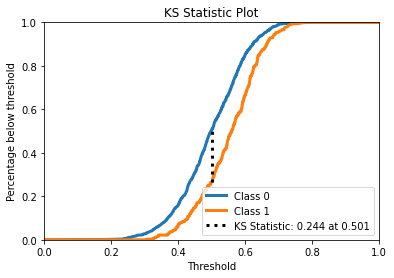

In [58]:
#possible cutoff for model- 0.501
plot_ks_statistic(test_prepared_encoded['df'],
                  test_prepared_encoded[['log_reg_bsln_good_proba', 'log_reg_bsln_proba']]);

#### seems like chosen threshold is better than default threshold in sklearn

In [59]:
calculate_metrics(test_prepared_encoded, 'log_reg_bsln_proba', 'df', cutoff=0.501)

AUC: 0.6218841037761776
F1: 0.47211155378486064
Gini: 0.2437682075523553


In [60]:
calculate_metrics(test_prepared_encoded, 'log_reg_bsln_proba', 'df')

AUC: 0.6180124223602484
F1: 0.46884272997032644
Gini: 0.2360248447204969


#### feature importance

In [61]:
pd.Series(log_reg_bsln.coef_[0], all_features_encoded).sort_values(ascending=False)

app_create_time_dayofyear_encoded                  4.394551
empl_type_encoded                                  2.378671
education_encoded                                  1.993190
education_area_encoded                             1.779874
gender_encoded                                     1.618693
region_encoded                                     1.579917
region_reg_encoded                                 1.377290
age_on_app_created                                 1.312662
fam_status_encoded                                 1.307617
empl_state_encoded                                 1.025139
qty_days_of_site_activity                          0.809962
property_encoded                                   0.646994
empl_worker_count_encoded                          0.457165
qty_days_to_app_on_last_live                       0.254251
qty_days_passed_from_behaviour_starts              0.252805
qty_platforms_used                                 0.234893
qty_devices_used                        

### Catboost

In [62]:
ctb_target_enc = CatBoostClassifier(n_estimators=300, learning_rate=0.03, max_depth=5, random_state=42,
                                    loss_function='Logloss',early_stopping_rounds=300, min_data_in_leaf=100, 
                                    verbose=2, class_weights=cw,
                                    custom_metric=['AUC', 'F1'])

In [63]:
ctb_target_enc.fit(
    train_prepared_encoded[all_features_encoded], train_prepared_encoded['df'],
    eval_set=(test_prepared_encoded[all_features_encoded], test_prepared_encoded['df']),
    verbose=2,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6648433	test: 0.6671547	best: 0.6671547 (0)	total: 5.48ms	remaining: 1.64s
2:	learn: 0.6153483	test: 0.6213285	best: 0.6213285 (2)	total: 20.1ms	remaining: 1.99s
4:	learn: 0.5730580	test: 0.5802725	best: 0.5802725 (4)	total: 27.3ms	remaining: 1.61s
6:	learn: 0.5357465	test: 0.5455984	best: 0.5455984 (6)	total: 34.7ms	remaining: 1.45s
8:	learn: 0.5046978	test: 0.5154524	best: 0.5154524 (8)	total: 41.4ms	remaining: 1.34s
10:	learn: 0.4778784	test: 0.4901832	best: 0.4901832 (10)	total: 46.4ms	remaining: 1.22s
12:	learn: 0.4535173	test: 0.4687382	best: 0.4687382 (12)	total: 51.7ms	remaining: 1.14s
14:	learn: 0.4338868	test: 0.4497919	best: 0.4497919 (14)	total: 58.5ms	remaining: 1.11s
16:	learn: 0.4165657	test: 0.4332598	best: 0.4332598 (16)	total: 65.9ms	remaining: 1.1s
18:	learn: 0.4014488	test: 0.4190278	best: 0.4190278 (18)	total: 71.6ms	remaining: 1.06s
20:	learn: 0.3888973	test: 0.4070975	best: 0.4070975 (20)	total: 77.7ms	remaining: 1.03s
22:	learn: 0.3775620	test: 0.396

208:	learn: 0.2740930	test: 0.3234946	best: 0.3234946 (208)	total: 812ms	remaining: 353ms
210:	learn: 0.2739900	test: 0.3234963	best: 0.3234896 (209)	total: 818ms	remaining: 345ms
212:	learn: 0.2737443	test: 0.3234821	best: 0.3234646 (211)	total: 824ms	remaining: 336ms
214:	learn: 0.2736151	test: 0.3234604	best: 0.3234604 (214)	total: 830ms	remaining: 328ms
216:	learn: 0.2733324	test: 0.3234501	best: 0.3234220 (215)	total: 839ms	remaining: 321ms
218:	learn: 0.2730700	test: 0.3234217	best: 0.3234217 (218)	total: 846ms	remaining: 313ms
220:	learn: 0.2727927	test: 0.3233597	best: 0.3233597 (220)	total: 853ms	remaining: 305ms
222:	learn: 0.2724233	test: 0.3233260	best: 0.3233260 (222)	total: 861ms	remaining: 297ms
224:	learn: 0.2721863	test: 0.3232587	best: 0.3232587 (224)	total: 865ms	remaining: 288ms
226:	learn: 0.2720513	test: 0.3232940	best: 0.3232301 (225)	total: 871ms	remaining: 280ms
228:	learn: 0.2717830	test: 0.3233017	best: 0.3232301 (225)	total: 877ms	remaining: 272ms
230:	learn

In [64]:
ctb_target_enc.get_best_score()

{'learn': {'F1:use_weights=false': 0.04093567251461988,
  'Logloss': 0.26353688373359146,
  'F1:use_weights=true': 0.04093567251461988},
 'validation': {'F1:use_weights=false': 0.0,
  'Logloss': 0.32265999800968115,
  'F1:use_weights=true': 0.0,
  'AUC': 0.6528884735887429}}

In [65]:
test_prepared_encoded['catboost_bsln_proba'] = ctb_target_enc.predict_proba(
    test_prepared_encoded[all_features_encoded])[:, 1]

test_prepared_encoded['catboost_bsln_good_proba'] = ctb_target_enc.predict_proba(
    test_prepared_encoded[all_features_encoded])[:, 0]

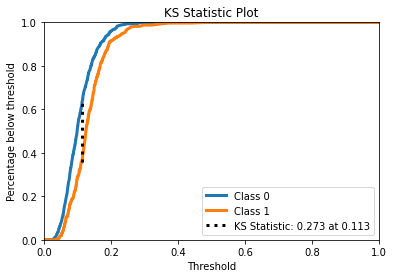

In [66]:
#possible cutoff for model- 0.113
plot_ks_statistic(test_prepared_encoded['df'],
                  test_prepared_encoded[['catboost_bsln_good_proba', 'catboost_bsln_proba']]);

#### seems like chosen threshold is better than default threshold in sklearn

In [67]:
calculate_metrics(test_prepared_encoded, 'catboost_bsln_proba', 'df', cutoff=0.113)

AUC: 0.6328223767383059
F1: 0.47586206896551725
Gini: 0.26564475347661176


In [68]:
calculate_metrics(test_prepared_encoded, 'catboost_bsln_proba', 'df')

AUC: 0.5
F1: 0.0
Gini: 0.0


#### feature importance

In [69]:
pd.Series(ctb_target_enc.feature_importances_, all_features_encoded).sort_values(ascending=False)

app_create_time_dayofyear_encoded                  21.522869
empl_type_encoded                                   7.814613
fam_status_encoded                                  4.759618
qty_days_since_passport_given                       4.633220
education_area_encoded                              4.269926
region_reg_encoded                                  4.087705
qty_days_to_app_on_last_live                        4.069203
qty_days_to_app_on_last_work                        4.041802
age_on_app_created                                  3.955949
quantity_child                                      3.760837
education_encoded                                   3.650867
region_encoded                                      3.452836
gender_encoded                                      3.141395
property_encoded                                    2.901394
empl_state_encoded                                  2.685340
app_create_time_weekday_encoded                     2.540400
qty_days_passed_from_beh

### GradientBoosting

In [70]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3, max_features='sqrt', 
                                 min_samples_split=100, min_samples_leaf=100)

In [71]:
gbc.fit(train_prepared_encoded[all_features_encoded], train_prepared_encoded['df'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [72]:
test_prepared_encoded['gbc_bsln_proba'] = gbc.predict_proba(
    test_prepared_encoded[all_features_encoded])[:, 1]

test_prepared_encoded['gbc_bsln_good_proba'] = gbc.predict_proba(
    test_prepared_encoded[all_features_encoded])[:, 0]

In [73]:
roc_auc_score(test_prepared_encoded['df'], test_prepared_encoded['gbc_bsln_proba'])

0.6449527290716209

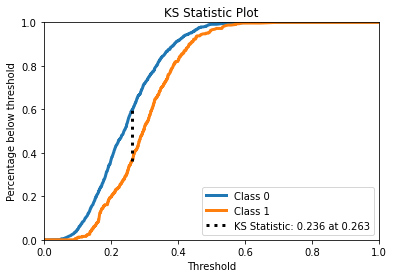

In [74]:
#possible cutoff for model- 0.263
plot_ks_statistic(test_prepared_encoded['df'],
                  test_prepared_encoded[['gbc_bsln_good_proba', 'gbc_bsln_proba']]);

#### seems like chosen threshold is better than default threshold in sklearn

In [75]:
calculate_metrics(test_prepared_encoded, 'gbc_bsln_proba', 'df', cutoff=0.263)

AUC: 0.6164424503930084
F1: 0.4596412556053812
Gini: 0.23288490078601676


In [76]:
calculate_metrics(test_prepared_encoded, 'gbc_bsln_proba', 'df')

AUC: 0.5142087616116089
F1: 0.07017543859649124
Gini: 0.028417523223217778


#### feature importance

In [77]:
pd.Series(gbc.feature_importances_, all_features_encoded).sort_values(ascending=False)

app_create_time_dayofyear_encoded                  0.184576
qty_days_since_passport_given                      0.072116
empl_type_encoded                                  0.062598
qty_days_to_app_on_last_work                       0.062113
qty_days_to_app_on_last_live                       0.058223
age_on_app_created                                 0.053477
monthly_income_cost_diff                           0.052487
qty_days_passed_from_behaviour_starts              0.047311
region_reg_encoded                                 0.040376
fam_status_encoded                                 0.040334
region_encoded                                     0.039180
education_encoded                                  0.037715
empl_state_encoded                                 0.031884
education_area_encoded                             0.028694
gender_encoded                                     0.027346
quantity_child                                     0.025970
qty_refs_used                           

# Stacking

In [78]:
appl_data.head()

,appl_id,app_crtime,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df,monthly_income_cost_diff,qty_days_to_app_on_last_work,work_on_last_work_less_than_year,work_on_last_work_less_than_six_month,work_on_last_work_less_than_three_month,work_on_last_work_less_than_one_month,age_on_app_created,is_same_live_and_reg,qty_days_since_passport_given,has_passport_more_than_once,qty_days_to_app_on_last_live,live_on_last_live_less_than_year,live_on_last_live_less_than_six_month,live_on_last_live_less_than_three_month,live_on_last_live_less_than_one_month,has_adult_child,large_family,app_created_date,app_create_time_weekday,app_create_time_dayofyear,app_create_time_month_end,app_create_time_month_start,app_create_time_quarter_start,app_create_time_quarter_end
0,1157589,2017-12-31 09:35:53+00:00,119804,1994-01-12,1,2010-10-08,4,1,3.0,5,2017-01-01,2017-01-01,8,10,NaT,3,4,NaN,NaN,7.0,2,15000.0,10000.0,NaN,5000.0,NaN,0,0,0,0,23,0,2641.0,0,364,1,1,1,1,0,0,2017-12-31,6,365,True,False,False,True
1,1159012,2017-12-31 20:05:37+00:00,120147,1994-02-14,2,2010-04-06,4,0,0.0,5,1994-02-01,1994-02-01,9,11,2013-05-01,4,1,6.0,1.0,NaN,6,8000.0,6000.0,NaN,2000.0,1705.0,0,0,0,1,23,0,2826.0,0,8734,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True
2,1157375,2017-12-31 08:18:56+00:00,119755,1984-10-20,2,2013-06-28,3,1,2.0,5,2012-05-01,2012-05-01,5,7,2015-12-01,10,1,10.0,6.0,6.0,7,15000.0,14000.0,NaN,1000.0,761.0,0,0,1,1,33,0,1647.0,1,2070,0,0,0,1,0,0,2017-12-31,6,365,True,False,False,True
3,1158541,2017-12-31 15:18:23+00:00,120042,1986-02-07,2,2012-09-27,4,0,0.0,5,1991-08-01,1991-08-01,8,10,2017-09-01,13,1,1.0,5.0,6.0,2,10000.0,5000.0,NaN,5000.0,121.0,1,1,1,1,31,0,1921.0,1,9649,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True
4,1157949,2017-12-31 11:25:38+00:00,119893,1992-06-26,2,2012-02-11,4,0,0.0,1,1992-06-01,1992-06-01,18,22,2014-08-01,3,1,10.0,5.0,3.0,1,7500.0,5000.0,NaN,2500.0,1248.0,0,0,1,1,25,0,2150.0,1,9344,0,0,0,0,0,0,2017-12-31,6,365,True,False,False,True


In [79]:
behave_on_site_aggregated.head()

,appl_id,app_crtime,client_id,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts
0,1157589,2017-12-31 09:35:53+00:00,119804,2017-12-31 09:35:39.153545+00:00,3,1,1,1,1,0
1,1159012,2017-12-31 20:05:37+00:00,120147,2017-12-31 20:05:09.351273+00:00,4,1,1,1,1,0
2,1157375,2017-12-31 08:18:56+00:00,119755,2017-12-31 08:18:43.603247+00:00,3,1,1,1,1,0
3,1158541,2017-12-31 15:18:23+00:00,120042,2017-12-31 15:18:12.687655+00:00,3,1,1,1,1,0
4,1157949,2017-12-31 11:25:38+00:00,119893,2017-12-31 11:25:25.621322+00:00,3,1,1,1,1,0


## Application data model

In [80]:
appl_data_categorical_features = list(set(categorical_features) & set(appl_data.columns))
appl_data_numeric_features = list(set(numeric_features) & set(appl_data.columns))

In [81]:
train_data_appl = appl_data[~appl_data.df.isnull()]
test_data_appl = appl_data[appl_data.df.isnull()]

In [82]:
prepared_appl_data, prepared_appl_data_encoded, appl_encoder, appl_transformer, \
all_feats_appl, all_feats_appl_encoded = prepare_dataset(train_data_appl,
                                                         cat_features=appl_data_categorical_features,
                                                         numeric_features=appl_data_numeric_features)

In [83]:
prepared_appl_data_encoded.head()

,appl_id,app_crtime,df,region_encoded,app_create_time_weekday_encoded,app_create_time_quarter_start_encoded,large_family_encoded,work_on_last_work_less_than_one_month_encoded,education_area_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,empl_worker_count_encoded,empl_state_encoded,is_same_live_and_reg_encoded,has_passport_more_than_once_encoded,live_on_last_live_less_than_year_encoded,work_on_last_work_less_than_three_month_encoded,fam_status_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,education_encoded,live_on_last_live_less_than_one_month_encoded,app_create_time_quarter_end_encoded,work_on_last_work_less_than_year_encoded,has_adult_child_encoded,empl_type_encoded,property_encoded,app_create_time_dayofyear_encoded,work_on_last_work_less_than_six_month_encoded,region_reg_encoded,gender_encoded,work_experience,qty_days_to_app_on_last_work,quantity_child,qty_days_to_app_on_last_live,max_age_child,qty_days_since_passport_given,age_on_app_created,monthly_income_cost_diff,app_crtime_date
3997,762157,2017-10-31 16:01:01+00:00,1,0.245033,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.214592,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.331429,0.271804,0.189189,0.240156,0.240143,0.202909,0.044643,0.047382,0.000000,0.006604,0.000000,0.297430,0.157895,0.490,2017-10-31
4042,761384,2017-10-31 11:12:33+00:00,1,0.223404,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.253704,0.248435,0.254645,0.248787,0.261301,0.199197,0.250949,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.240156,0.202020,0.202909,0.017857,0.056137,0.166667,0.041199,0.104167,0.128687,0.105263,0.498,2017-10-31
4043,762215,2017-10-31 16:20:42+00:00,1,0.277311,0.24127,0.248034,0.248848,0.252364,0.230277,0.217391,0.248066,0.240106,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.253923,0.229113,0.248488,0.269149,0.246901,0.273109,0.271804,0.189189,0.258427,0.258824,0.273260,0.071429,0.015908,0.000000,0.014467,0.000000,0.274199,0.140351,0.496,2017-10-31
4071,762424,2017-10-31 18:01:52+00:00,0,0.279661,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.242148,0.248435,0.254645,0.248787,0.261301,0.281150,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.258427,0.258824,0.202909,0.044643,0.031702,0.000000,0.028934,0.000000,0.178106,0.105263,0.508,2017-10-31
4086,761818,2017-10-31 13:47:08+00:00,0,0.245033,0.24127,0.248034,0.248848,0.252364,0.276860,0.217391,0.248066,0.240106,0.242148,0.248435,0.254645,0.248787,0.261301,0.264286,0.250949,0.258283,0.253923,0.265724,0.248488,0.269149,0.246901,0.267937,0.271804,0.189189,0.258427,0.240143,0.202909,0.026786,0.021173,0.000000,0.432593,0.000000,0.151496,0.070175,0.492,2017-10-31


In [84]:
appl_train_prepared_encoded, appl_test_prepared_encoded = train_test_split(prepared_appl_data_encoded)

### Gradient Boosting

In [85]:
gbc_appl = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3, max_features='sqrt', 
                                 min_samples_split=100, min_samples_leaf=100)

In [86]:
gbc_appl.fit(appl_train_prepared_encoded[all_feats_appl_encoded], appl_train_prepared_encoded['df'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [87]:
appl_test_prepared_encoded['gbc_bsln_proba'] = gbc_appl.predict_proba(
    appl_test_prepared_encoded[all_feats_appl_encoded])[:, 1]

appl_test_prepared_encoded['gbc_bsln_good_proba'] = gbc_appl.predict_proba(
    appl_test_prepared_encoded[all_feats_appl_encoded])[:, 0]

In [88]:
roc_auc_score(appl_test_prepared_encoded['df'], appl_test_prepared_encoded['gbc_bsln_proba'])

0.6442862639476721

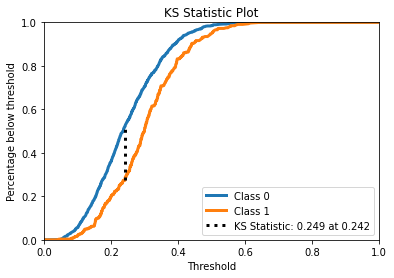

In [89]:
#possible cutoff for model- 0.28
plot_ks_statistic(appl_test_prepared_encoded['df'],
                  appl_test_prepared_encoded[['gbc_bsln_good_proba', 'gbc_bsln_proba']]);

#### seems like chosen threshold is better than default threshold in sklearn

In [90]:
calculate_metrics(appl_test_prepared_encoded, 'gbc_bsln_proba', 'df', cutoff=0.28)

AUC: 0.6165936074314297
F1: 0.4546553808948005
Gini: 0.23318721486285932


In [91]:
calculate_metrics(appl_test_prepared_encoded, 'gbc_bsln_proba', 'df')

AUC: 0.5186541526960919
F1: 0.09631728045325778
Gini: 0.03730830539218388


#### feature importance

In [92]:
pd.Series(gbc_appl.feature_importances_, all_feats_appl_encoded).sort_values(ascending=False)

app_create_time_dayofyear_encoded                  0.200767
qty_days_since_passport_given                      0.069507
qty_days_to_app_on_last_live                       0.065040
qty_days_to_app_on_last_work                       0.063467
empl_type_encoded                                  0.060590
age_on_app_created                                 0.057906
monthly_income_cost_diff                           0.057046
education_area_encoded                             0.049048
fam_status_encoded                                 0.038719
empl_state_encoded                                 0.036666
region_reg_encoded                                 0.036330
app_create_time_weekday_encoded                    0.033531
region_encoded                                     0.033495
work_experience                                    0.030700
max_age_child                                      0.029977
quantity_child                                     0.027493
gender_encoded                          

## Behaviour data model

In [93]:
beh_data_categorical_features = list(set(categorical_features) & set(behave_on_site_aggregated.columns))
beh_data_numeric_features = list(set(numeric_features) & set(behave_on_site_aggregated.columns))

In [94]:
behave_on_site_aggregated.head()

,appl_id,app_crtime,client_id,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts
0,1157589,2017-12-31 09:35:53+00:00,119804,2017-12-31 09:35:39.153545+00:00,3,1,1,1,1,0
1,1159012,2017-12-31 20:05:37+00:00,120147,2017-12-31 20:05:09.351273+00:00,4,1,1,1,1,0
2,1157375,2017-12-31 08:18:56+00:00,119755,2017-12-31 08:18:43.603247+00:00,3,1,1,1,1,0
3,1158541,2017-12-31 15:18:23+00:00,120042,2017-12-31 15:18:12.687655+00:00,3,1,1,1,1,0
4,1157949,2017-12-31 11:25:38+00:00,119893,2017-12-31 11:25:25.621322+00:00,3,1,1,1,1,0


In [95]:
behave_on_site_aggregated = pd.merge(behave_on_site_aggregated, appl_data[['client_id', 'df']], on='client_id')

In [96]:
train_data_beh = behave_on_site_aggregated[~behave_on_site_aggregated.df.isnull()]
test_data_beh = behave_on_site_aggregated[behave_on_site_aggregated.df.isnull()]

In [97]:
train_data_beh.head()

,appl_id,app_crtime,client_id,last_site_activity,qty_refs_used,qty_browsers_used,qty_platforms_used,qty_days_of_site_activity,qty_devices_used,qty_days_passed_from_behaviour_starts,df
3997,762157,2017-10-31 16:01:01+00:00,87198,2017-10-31 16:00:52.677855+00:00,3,1,1,1,1,0,bad
4042,761384,2017-10-31 11:12:33+00:00,50111,2017-10-31 11:11:51.842310+00:00,19,2,2,5,1,120,bad
4043,762215,2017-10-31 16:20:42+00:00,78479,2017-10-31 16:20:15.661290+00:00,7,1,1,3,1,24,bad
4071,762424,2017-10-31 18:01:52+00:00,87254,2017-10-31 18:01:42.708911+00:00,4,1,1,1,1,0,good
4086,761818,2017-10-31 13:47:08+00:00,87108,2017-10-31 13:46:54.552017+00:00,4,1,1,1,1,0,good


In [98]:
prepared_beh_data, prepared_beh_data_encoded, beh_encoder, beh_transformer, \
all_feats_beh, all_feats_beh_encoded = prepare_dataset(train_data_beh,
                                                         cat_features=beh_data_categorical_features,
                                                         numeric_features=beh_data_numeric_features)

In [99]:
prepared_beh_data_encoded.head()

,appl_id,app_crtime,df,qty_refs_used,qty_devices_used,qty_platforms_used,qty_days_passed_from_behaviour_starts,qty_days_of_site_activity,qty_browsers_used,app_crtime_date
3997,762157,2017-10-31 16:01:01+00:00,1,0.058824,0.0,0.0,0.000000,0.000000,0.000000,2017-10-31
4042,761384,2017-10-31 11:12:33+00:00,1,0.529412,0.0,0.5,0.833333,0.129032,0.333333,2017-10-31
4043,762215,2017-10-31 16:20:42+00:00,1,0.176471,0.0,0.0,0.166667,0.064516,0.000000,2017-10-31
4071,762424,2017-10-31 18:01:52+00:00,0,0.088235,0.0,0.0,0.000000,0.000000,0.000000,2017-10-31
4086,761818,2017-10-31 13:47:08+00:00,0,0.088235,0.0,0.0,0.000000,0.000000,0.000000,2017-10-31


In [100]:
beh_train_prepared_encoded, beh_test_prepared_encoded = train_test_split(prepared_beh_data_encoded)

### Gradient Boosting

In [101]:
gbc_beh = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3, max_features='sqrt', 
                                 min_samples_split=100, min_samples_leaf=100)

In [102]:
gbc_beh.fit(beh_train_prepared_encoded[all_feats_beh_encoded], beh_train_prepared_encoded['df'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [103]:
beh_test_prepared_encoded['gbc_bsln_proba'] = gbc_beh.predict_proba(
    beh_test_prepared_encoded[all_feats_beh_encoded])[:, 1]

beh_test_prepared_encoded['gbc_bsln_good_proba'] = gbc_beh.predict_proba(
    beh_test_prepared_encoded[all_feats_beh_encoded])[:, 0]

In [104]:
roc_auc_score(beh_test_prepared_encoded['df'], beh_test_prepared_encoded['gbc_bsln_proba'])

0.5355442340460617

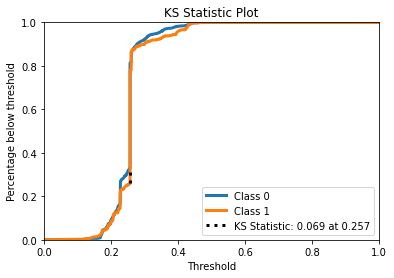

In [105]:
#possible cutoff for model- 0.258
plot_ks_statistic(beh_test_prepared_encoded['df'],
                  beh_test_prepared_encoded[['gbc_bsln_good_proba', 'gbc_bsln_proba']]);

#### seems like chosen threshold is better than default threshold in sklearn

In [106]:
calculate_metrics(beh_test_prepared_encoded, 'gbc_bsln_proba', 'df', cutoff=0.258)

AUC: 0.5183277909085913
F1: 0.2557726465364121
Gini: 0.036655581817182536


In [107]:
calculate_metrics(beh_test_prepared_encoded, 'gbc_bsln_proba', 'df')

AUC: 0.5
F1: 0.0
Gini: 0.0


#### feature importance

In [108]:
pd.Series(gbc_beh.feature_importances_, all_feats_beh_encoded).sort_values(ascending=False)

qty_refs_used                            0.402569
qty_days_passed_from_behaviour_starts    0.385111
qty_days_of_site_activity                0.119967
qty_platforms_used                       0.053626
qty_browsers_used                        0.038727
qty_devices_used                         0.000000
dtype: float64

### stack two models

In [109]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [110]:
prepared_appl_data_encoded.head(3)

,appl_id,app_crtime,df,region_encoded,app_create_time_weekday_encoded,app_create_time_quarter_start_encoded,large_family_encoded,work_on_last_work_less_than_one_month_encoded,education_area_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,empl_worker_count_encoded,empl_state_encoded,is_same_live_and_reg_encoded,has_passport_more_than_once_encoded,live_on_last_live_less_than_year_encoded,work_on_last_work_less_than_three_month_encoded,fam_status_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,education_encoded,live_on_last_live_less_than_one_month_encoded,app_create_time_quarter_end_encoded,work_on_last_work_less_than_year_encoded,has_adult_child_encoded,empl_type_encoded,property_encoded,app_create_time_dayofyear_encoded,work_on_last_work_less_than_six_month_encoded,region_reg_encoded,gender_encoded,work_experience,qty_days_to_app_on_last_work,quantity_child,qty_days_to_app_on_last_live,max_age_child,qty_days_since_passport_given,age_on_app_created,monthly_income_cost_diff,app_crtime_date
3997,762157,2017-10-31 16:01:01+00:00,1,0.245033,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.214592,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.331429,0.271804,0.189189,0.240156,0.240143,0.202909,0.044643,0.047382,0.000000,0.006604,0.000000,0.297430,0.157895,0.490,2017-10-31
4042,761384,2017-10-31 11:12:33+00:00,1,0.223404,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.253704,0.248435,0.254645,0.248787,0.261301,0.199197,0.250949,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.240156,0.202020,0.202909,0.017857,0.056137,0.166667,0.041199,0.104167,0.128687,0.105263,0.498,2017-10-31
4043,762215,2017-10-31 16:20:42+00:00,1,0.277311,0.24127,0.248034,0.248848,0.252364,0.230277,0.217391,0.248066,0.240106,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.253923,0.229113,0.248488,0.269149,0.246901,0.273109,0.271804,0.189189,0.258427,0.258824,0.273260,0.071429,0.015908,0.000000,0.014467,0.000000,0.274199,0.140351,0.496,2017-10-31


In [111]:
prepared_beh_data_encoded.head(3)

,appl_id,app_crtime,df,qty_refs_used,qty_devices_used,qty_platforms_used,qty_days_passed_from_behaviour_starts,qty_days_of_site_activity,qty_browsers_used,app_crtime_date
3997,762157,2017-10-31 16:01:01+00:00,1,0.058824,0.0,0.0,0.000000,0.000000,0.000000,2017-10-31
4042,761384,2017-10-31 11:12:33+00:00,1,0.529412,0.0,0.5,0.833333,0.129032,0.333333,2017-10-31
4043,762215,2017-10-31 16:20:42+00:00,1,0.176471,0.0,0.0,0.166667,0.064516,0.000000,2017-10-31


In [112]:
prepared_data_for_stacking = pd.merge(prepared_appl_data_encoded,
                                      prepared_beh_data_encoded[['appl_id', 'qty_days_of_site_activity',
                                                                'qty_refs_used', 'qty_platforms_used',
                                                                'qty_days_passed_from_behaviour_starts',
                                                                'qty_browsers_used', 'qty_devices_used']],
                                      on='appl_id')

In [113]:
prepared_data_for_stacking.head()

,appl_id,app_crtime,df,region_encoded,app_create_time_weekday_encoded,app_create_time_quarter_start_encoded,large_family_encoded,work_on_last_work_less_than_one_month_encoded,education_area_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,empl_worker_count_encoded,empl_state_encoded,is_same_live_and_reg_encoded,has_passport_more_than_once_encoded,live_on_last_live_less_than_year_encoded,work_on_last_work_less_than_three_month_encoded,fam_status_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,education_encoded,live_on_last_live_less_than_one_month_encoded,app_create_time_quarter_end_encoded,work_on_last_work_less_than_year_encoded,has_adult_child_encoded,empl_type_encoded,property_encoded,app_create_time_dayofyear_encoded,work_on_last_work_less_than_six_month_encoded,region_reg_encoded,gender_encoded,work_experience,qty_days_to_app_on_last_work,quantity_child,qty_days_to_app_on_last_live,max_age_child,qty_days_since_passport_given,age_on_app_created,monthly_income_cost_diff,app_crtime_date,qty_days_of_site_activity,qty_refs_used,qty_platforms_used,qty_days_passed_from_behaviour_starts,qty_browsers_used,qty_devices_used
0,762157,2017-10-31 16:01:01+00:00,1,0.245033,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.214592,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.331429,0.271804,0.189189,0.240156,0.240143,0.202909,0.044643,0.047382,0.000000,0.006604,0.000000,0.297430,0.157895,0.490,2017-10-31,0.000000,0.058824,0.0,0.000000,0.000000,0.0
1,761384,2017-10-31 11:12:33+00:00,1,0.223404,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.253704,0.248435,0.254645,0.248787,0.261301,0.199197,0.250949,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.240156,0.202020,0.202909,0.017857,0.056137,0.166667,0.041199,0.104167,0.128687,0.105263,0.498,2017-10-31,0.129032,0.529412,0.5,0.833333,0.333333,0.0
2,762215,2017-10-31 16:20:42+00:00,1,0.277311,0.24127,0.248034,0.248848,0.252364,0.230277,0.217391,0.248066,0.240106,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.253923,0.229113,0.248488,0.269149,0.246901,0.273109,0.271804,0.189189,0.258427,0.258824,0.273260,0.071429,0.015908,0.000000,0.014467,0.000000,0.274199,0.140351,0.496,2017-10-31,0.064516,0.176471,0.0,0.166667,0.000000,0.0
3,762424,2017-10-31 18:01:52+00:00,0,0.279661,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.242148,0.248435,0.254645,0.248787,0.261301,0.281150,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.258427,0.258824,0.202909,0.044643,0.031702,0.000000,0.028934,0.000000,0.178106,0.105263,0.508,2017-10-31,0.000000,0.088235,0.0,0.000000,0.000000,0.0
4,761818,2017-10-31 13:47:08+00:00,0,0.245033,0.24127,0.248034,0.248848,0.252364,0.276860,0.217391,0.248066,0.240106,0.242148,0.248435,0.254645,0.248787,0.261301,0.264286,0.250949,0.258283,0.253923,0.265724,0.248488,0.269149,0.246901,0.267937,0.271804,0.189189,0.258427,0.240143,0.202909,0.026786,0.021173,0.000000,0.432593,0.000000,0.151496,0.070175,0.492,2017-10-31,0.000000,0.088235,0.0,0.000000,0.000000,0.0


In [114]:
all_features_stacking = all_feats_appl_encoded + all_feats_beh_encoded

In [115]:
for train, test in skf.split(prepared_data_for_stacking[all_features_stacking],
                            prepared_data_for_stacking['df']):
    
    gbc_appl.fit(prepared_data_for_stacking.loc[train, all_feats_appl_encoded],
                prepared_data_for_stacking.loc[train, 'df'])
    gbc_beh.fit(prepared_data_for_stacking.loc[train, all_feats_beh_encoded],
               prepared_data_for_stacking.loc[train, 'df'])
    
    prepared_data_for_stacking.loc[test, 'appl_mdl_proba'] = gbc_appl.predict_proba(
        prepared_data_for_stacking.loc[test, all_feats_appl_encoded])[:, 1]
    
    prepared_data_for_stacking.loc[test, 'beh_mdl_proba'] = gbc_beh.predict_proba(
        prepared_data_for_stacking.loc[test, all_feats_beh_encoded])[:, 1]

In [116]:
prepared_data_for_stacking.head()

,appl_id,app_crtime,df,region_encoded,app_create_time_weekday_encoded,app_create_time_quarter_start_encoded,large_family_encoded,work_on_last_work_less_than_one_month_encoded,education_area_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,empl_worker_count_encoded,empl_state_encoded,is_same_live_and_reg_encoded,has_passport_more_than_once_encoded,live_on_last_live_less_than_year_encoded,work_on_last_work_less_than_three_month_encoded,fam_status_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,education_encoded,live_on_last_live_less_than_one_month_encoded,app_create_time_quarter_end_encoded,work_on_last_work_less_than_year_encoded,has_adult_child_encoded,empl_type_encoded,property_encoded,app_create_time_dayofyear_encoded,work_on_last_work_less_than_six_month_encoded,region_reg_encoded,gender_encoded,work_experience,qty_days_to_app_on_last_work,quantity_child,qty_days_to_app_on_last_live,max_age_child,qty_days_since_passport_given,age_on_app_created,monthly_income_cost_diff,app_crtime_date,qty_days_of_site_activity,qty_refs_used,qty_platforms_used,qty_days_passed_from_behaviour_starts,qty_browsers_used,qty_devices_used,appl_mdl_proba,beh_mdl_proba
0,762157,2017-10-31 16:01:01+00:00,1,0.245033,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.214592,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.331429,0.271804,0.189189,0.240156,0.240143,0.202909,0.044643,0.047382,0.000000,0.006604,0.000000,0.297430,0.157895,0.490,2017-10-31,0.000000,0.058824,0.0,0.000000,0.000000,0.0,0.288857,0.258654
1,761384,2017-10-31 11:12:33+00:00,1,0.223404,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.253704,0.248435,0.254645,0.248787,0.261301,0.199197,0.250949,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.240156,0.202020,0.202909,0.017857,0.056137,0.166667,0.041199,0.104167,0.128687,0.105263,0.498,2017-10-31,0.129032,0.529412,0.5,0.833333,0.333333,0.0,0.055092,0.211874
2,762215,2017-10-31 16:20:42+00:00,1,0.277311,0.24127,0.248034,0.248848,0.252364,0.230277,0.217391,0.248066,0.240106,0.242148,0.248435,0.242173,0.236301,0.261301,0.264286,0.229706,0.218391,0.253923,0.229113,0.248488,0.269149,0.246901,0.273109,0.271804,0.189189,0.258427,0.258824,0.273260,0.071429,0.015908,0.000000,0.014467,0.000000,0.274199,0.140351,0.496,2017-10-31,0.064516,0.176471,0.0,0.166667,0.000000,0.0,0.261193,0.281890
3,762424,2017-10-31 18:01:52+00:00,0,0.279661,0.24127,0.248034,0.248848,0.252364,0.285181,0.217391,0.248066,0.246377,0.242148,0.248435,0.254645,0.248787,0.261301,0.281150,0.229706,0.218391,0.270957,0.229113,0.248488,0.241346,0.246901,0.267937,0.222919,0.189189,0.258427,0.258824,0.202909,0.044643,0.031702,0.000000,0.028934,0.000000,0.178106,0.105263,0.508,2017-10-31,0.000000,0.088235,0.0,0.000000,0.000000,0.0,0.168458,0.221473
4,761818,2017-10-31 13:47:08+00:00,0,0.245033,0.24127,0.248034,0.248848,0.252364,0.276860,0.217391,0.248066,0.240106,0.242148,0.248435,0.254645,0.248787,0.261301,0.264286,0.250949,0.258283,0.253923,0.265724,0.248488,0.269149,0.246901,0.267937,0.271804,0.189189,0.258427,0.240143,0.202909,0.026786,0.021173,0.000000,0.432593,0.000000,0.151496,0.070175,0.492,2017-10-31,0.000000,0.088235,0.0,0.000000,0.000000,0.0,0.194449,0.230569


In [117]:
prepared_data_for_stacking.appl_mdl_proba.hasnans, prepared_data_for_stacking.beh_mdl_proba.hasnans

(False, False)

In [118]:
train_stacking, test_stacking = train_test_split(prepared_data_for_stacking)

In [119]:
ensemble_clf = LogisticRegression(C=1, random_state=42, class_weight='balanced', max_iter=1000)

In [120]:
ensemble_clf.fit(train_stacking[['appl_mdl_proba', 'beh_mdl_proba']],
                train_stacking['df'])

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [121]:
test_stacking['ensemble_proba'] = ensemble_clf.predict_proba(
    test_stacking[['appl_mdl_proba', 'beh_mdl_proba']])[:, 1]

In [122]:
test_stacking['ensemble_good_proba'] = ensemble_clf.predict_proba(
    test_stacking[['appl_mdl_proba', 'beh_mdl_proba']])[:, 0]

In [123]:
roc_auc_score(test_stacking['df'], 
              test_stacking['ensemble_proba'])

0.6340316330456769

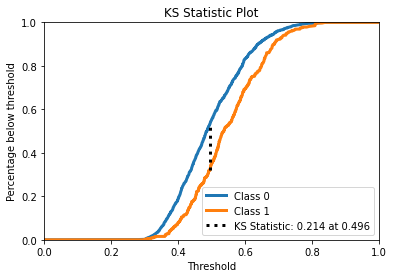

In [124]:
#possible cutoff for model- 0.530
plot_ks_statistic(test_stacking['df'],
                  test_stacking[['ensemble_good_proba', 'ensemble_proba']]);

#### seems like chosen threshold is better than default threshold in sklearn

In [125]:
calculate_metrics(test_stacking, 'ensemble_proba', 'df', cutoff=0.53)

AUC: 0.5795601330181939
F1: 0.4103194103194103
Gini: 0.15912026603638774


In [126]:
calculate_metrics(test_stacking, 'ensemble_proba', 'df')

AUC: 0.6009763370527126
F1: 0.4472843450479233
Gini: 0.20195267410542517


### Get predictions for test

In [128]:
prepared_data_test, prepared_data_encoded_test, fitted_encoder_test, fitted_transformer_test, \
all_features, all_features_encoded = prepare_dataset(test_data, categorical_features, numeric_features)

In [133]:
encoded_feats = list(map(lambda x: x + '_encoded', categorical_features))

In [135]:
prepared_data_encoded_test[encoded_feats] = fitted_encoder.transform(test_data[categorical_features])

In [136]:
prepared_data_encoded_test[numeric_features] = fitted_transformer.transform(test_data[numeric_features])

In [137]:
prepared_data_encoded_test.head()

,appl_id,app_crtime,df,gender_encoded,fam_status_encoded,property_encoded,region_encoded,region_reg_encoded,empl_state_encoded,empl_type_encoded,empl_worker_count_encoded,education_area_encoded,education_encoded,work_on_last_work_less_than_year_encoded,work_on_last_work_less_than_six_month_encoded,work_on_last_work_less_than_three_month_encoded,work_on_last_work_less_than_one_month_encoded,is_same_live_and_reg_encoded,live_on_last_live_less_than_year_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,live_on_last_live_less_than_one_month_encoded,has_adult_child_encoded,large_family_encoded,has_passport_more_than_once_encoded,app_create_time_dayofyear_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,app_create_time_quarter_end_encoded,app_create_time_quarter_start_encoded,app_create_time_weekday_encoded,max_age_child,work_experience,monthly_income_cost_diff,qty_days_to_app_on_last_work,age_on_app_created,qty_days_since_passport_given,qty_days_to_app_on_last_live,qty_browsers_used,qty_days_of_site_activity,qty_days_passed_from_behaviour_starts,qty_devices_used,qty_platforms_used,qty_refs_used,quantity_child,app_crtime_date
0,1157589,2017-12-31 09:35:53+00:00,NaN,0.202909,0.264286,0.271804,0.211679,0.218097,0.233129,0.230068,0.230068,0.195652,0.253923,0.241346,0.240156,0.225000,0.223301,0.248435,0.236301,0.229706,0.218391,0.229113,0.246901,0.248848,0.242173,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.022246,0.000446,0.480001,0.000343,-0.314134,0.011137,0.000211,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.004167,2017-12-31
1,1159012,2017-12-31 20:05:37+00:00,NaN,0.273260,0.264286,0.271804,0.229885,0.208163,0.242148,0.273109,0.214592,0.285181,0.270957,0.241346,0.240156,0.225000,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.242173,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.000595,0.480001,0.000349,-0.314134,0.011138,0.000232,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.026369,0.000000,2017-12-31
2,1157375,2017-12-31 08:18:56+00:00,NaN,0.273260,0.199197,0.271804,0.323529,0.323944,0.242148,0.171053,0.246377,0.175084,0.116279,0.241346,0.240156,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.229113,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021893,0.001488,0.480001,0.000346,-0.310824,0.011132,0.000215,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.004167,2017-12-31
3,1158541,2017-12-31 15:18:23+00:00,NaN,0.273260,0.264286,0.271804,0.211679,0.218097,0.242148,0.186747,0.240106,0.175084,0.253923,0.269149,0.258427,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.001935,0.480001,0.000344,-0.311486,0.011133,0.000235,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.000000,2017-12-31
4,1157949,2017-12-31 11:25:38+00:00,NaN,0.273260,0.264286,0.222919,0.245033,0.240143,0.242148,0.171053,0.240106,0.253333,0.214866,0.241346,0.240156,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.000446,0.480001,0.000347,-0.313472,0.011135,0.000234,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.000000,2017-12-31


In [138]:
prepared_data_encoded_test['log_reg_proba'] = log_reg_bsln.predict_proba(
    prepared_data_encoded_test[all_features_encoded])[:, 1]

In [139]:
prepared_data_encoded_test['gradient_boosting_proba'] = gbc.predict_proba(
    prepared_data_encoded_test[all_features_encoded])[:, 1]

In [140]:
prepared_data_encoded_test.head()

,appl_id,app_crtime,df,gender_encoded,fam_status_encoded,property_encoded,region_encoded,region_reg_encoded,empl_state_encoded,empl_type_encoded,empl_worker_count_encoded,education_area_encoded,education_encoded,work_on_last_work_less_than_year_encoded,work_on_last_work_less_than_six_month_encoded,work_on_last_work_less_than_three_month_encoded,work_on_last_work_less_than_one_month_encoded,is_same_live_and_reg_encoded,live_on_last_live_less_than_year_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,live_on_last_live_less_than_one_month_encoded,has_adult_child_encoded,large_family_encoded,has_passport_more_than_once_encoded,app_create_time_dayofyear_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,app_create_time_quarter_end_encoded,app_create_time_quarter_start_encoded,app_create_time_weekday_encoded,max_age_child,work_experience,monthly_income_cost_diff,qty_days_to_app_on_last_work,age_on_app_created,qty_days_since_passport_given,qty_days_to_app_on_last_live,qty_browsers_used,qty_days_of_site_activity,qty_days_passed_from_behaviour_starts,qty_devices_used,qty_platforms_used,qty_refs_used,quantity_child,app_crtime_date,log_reg_proba,gradient_boosting_proba
0,1157589,2017-12-31 09:35:53+00:00,NaN,0.202909,0.264286,0.271804,0.211679,0.218097,0.233129,0.230068,0.230068,0.195652,0.253923,0.241346,0.240156,0.225000,0.223301,0.248435,0.236301,0.229706,0.218391,0.229113,0.246901,0.248848,0.242173,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.022246,0.000446,0.480001,0.000343,-0.314134,0.011137,0.000211,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.004167,2017-12-31,0.315652,0.102420
1,1159012,2017-12-31 20:05:37+00:00,NaN,0.273260,0.264286,0.271804,0.229885,0.208163,0.242148,0.273109,0.214592,0.285181,0.270957,0.241346,0.240156,0.225000,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.242173,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.000595,0.480001,0.000349,-0.314134,0.011138,0.000232,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.026369,0.000000,2017-12-31,0.400727,0.210889
2,1157375,2017-12-31 08:18:56+00:00,NaN,0.273260,0.199197,0.271804,0.323529,0.323944,0.242148,0.171053,0.246377,0.175084,0.116279,0.241346,0.240156,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.229113,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021893,0.001488,0.480001,0.000346,-0.310824,0.011132,0.000215,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.004167,2017-12-31,0.286377,0.130791
3,1158541,2017-12-31 15:18:23+00:00,NaN,0.273260,0.264286,0.271804,0.211679,0.218097,0.242148,0.186747,0.240106,0.175084,0.253923,0.269149,0.258427,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.001935,0.480001,0.000344,-0.311486,0.011133,0.000235,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.000000,2017-12-31,0.296483,0.117963
4,1157949,2017-12-31 11:25:38+00:00,NaN,0.273260,0.264286,0.222919,0.245033,0.240143,0.242148,0.171053,0.240106,0.253333,0.214866,0.241346,0.240156,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.000446,0.480001,0.000347,-0.313472,0.011135,0.000234,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.000000,2017-12-31,0.315104,0.126625


In [142]:
#link to Kolmogorov-Smirnov plots for Log Regression and Gradient Boosting
GBC_CUTOFF = 0.263
LOG_REG_CUTOFF = 0.501

In [143]:
prepared_data_encoded_test['df_log_reg'] = (prepared_data_encoded_test['log_reg_proba'] >
                                            LOG_REG_CUTOFF).astype(int)

prepared_data_encoded_test['df_gradient_boosting'] = (prepared_data_encoded_test['gradient_boosting_proba'] >
                                            GBC_CUTOFF).astype(int)

In [144]:
prepared_data_encoded_test.head()

,appl_id,app_crtime,df,gender_encoded,fam_status_encoded,property_encoded,region_encoded,region_reg_encoded,empl_state_encoded,empl_type_encoded,empl_worker_count_encoded,education_area_encoded,education_encoded,work_on_last_work_less_than_year_encoded,work_on_last_work_less_than_six_month_encoded,work_on_last_work_less_than_three_month_encoded,work_on_last_work_less_than_one_month_encoded,is_same_live_and_reg_encoded,live_on_last_live_less_than_year_encoded,live_on_last_live_less_than_six_month_encoded,live_on_last_live_less_than_three_month_encoded,live_on_last_live_less_than_one_month_encoded,has_adult_child_encoded,large_family_encoded,has_passport_more_than_once_encoded,app_create_time_dayofyear_encoded,app_create_time_month_end_encoded,app_create_time_month_start_encoded,app_create_time_quarter_end_encoded,app_create_time_quarter_start_encoded,app_create_time_weekday_encoded,max_age_child,work_experience,monthly_income_cost_diff,qty_days_to_app_on_last_work,age_on_app_created,qty_days_since_passport_given,qty_days_to_app_on_last_live,qty_browsers_used,qty_days_of_site_activity,qty_days_passed_from_behaviour_starts,qty_devices_used,qty_platforms_used,qty_refs_used,quantity_child,app_crtime_date,log_reg_proba,gradient_boosting_proba,df_log_reg,df_gradient_boosting
0,1157589,2017-12-31 09:35:53+00:00,NaN,0.202909,0.264286,0.271804,0.211679,0.218097,0.233129,0.230068,0.230068,0.195652,0.253923,0.241346,0.240156,0.225000,0.223301,0.248435,0.236301,0.229706,0.218391,0.229113,0.246901,0.248848,0.242173,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.022246,0.000446,0.480001,0.000343,-0.314134,0.011137,0.000211,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.004167,2017-12-31,0.315652,0.102420,0,0
1,1159012,2017-12-31 20:05:37+00:00,NaN,0.273260,0.264286,0.271804,0.229885,0.208163,0.242148,0.273109,0.214592,0.285181,0.270957,0.241346,0.240156,0.225000,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.242173,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.000595,0.480001,0.000349,-0.314134,0.011138,0.000232,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.026369,0.000000,2017-12-31,0.400727,0.210889,0,0
2,1157375,2017-12-31 08:18:56+00:00,NaN,0.273260,0.199197,0.271804,0.323529,0.323944,0.242148,0.171053,0.246377,0.175084,0.116279,0.241346,0.240156,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.229113,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021893,0.001488,0.480001,0.000346,-0.310824,0.011132,0.000215,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.004167,2017-12-31,0.286377,0.130791,0,0
3,1158541,2017-12-31 15:18:23+00:00,NaN,0.273260,0.264286,0.271804,0.211679,0.218097,0.242148,0.186747,0.240106,0.175084,0.253923,0.269149,0.258427,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.001935,0.480001,0.000344,-0.311486,0.011133,0.000235,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.000000,2017-12-31,0.296483,0.117963,0,0
4,1157949,2017-12-31 11:25:38+00:00,NaN,0.273260,0.264286,0.222919,0.245033,0.240143,0.242148,0.171053,0.240106,0.253333,0.214866,0.241346,0.240156,0.261301,0.252364,0.248435,0.248787,0.250949,0.258283,0.265724,0.246901,0.248848,0.254645,0.247876,0.217391,0.248066,0.176471,0.248034,0.28702,0.021186,0.000446,0.480001,0.000347,-0.313472,0.011135,0.000234,-0.333333,-0.032258,0.0,-1.0,-0.5,-0.027383,0.000000,2017-12-31,0.315104,0.126625,0,0


In [145]:
prepared_data_encoded_test.df_log_reg.value_counts(normalize=True)

0    0.996815
1    0.003185
Name: df_log_reg, dtype: float64

In [146]:
prepared_data_encoded_test.df_gradient_boosting.value_counts(normalize=True)

0    0.871877
1    0.128123
Name: df_gradient_boosting, dtype: float64

In [147]:
prepared_data_encoded_test.to_csv('test_data_scores.csv', index=False)

# EDA, feature selection

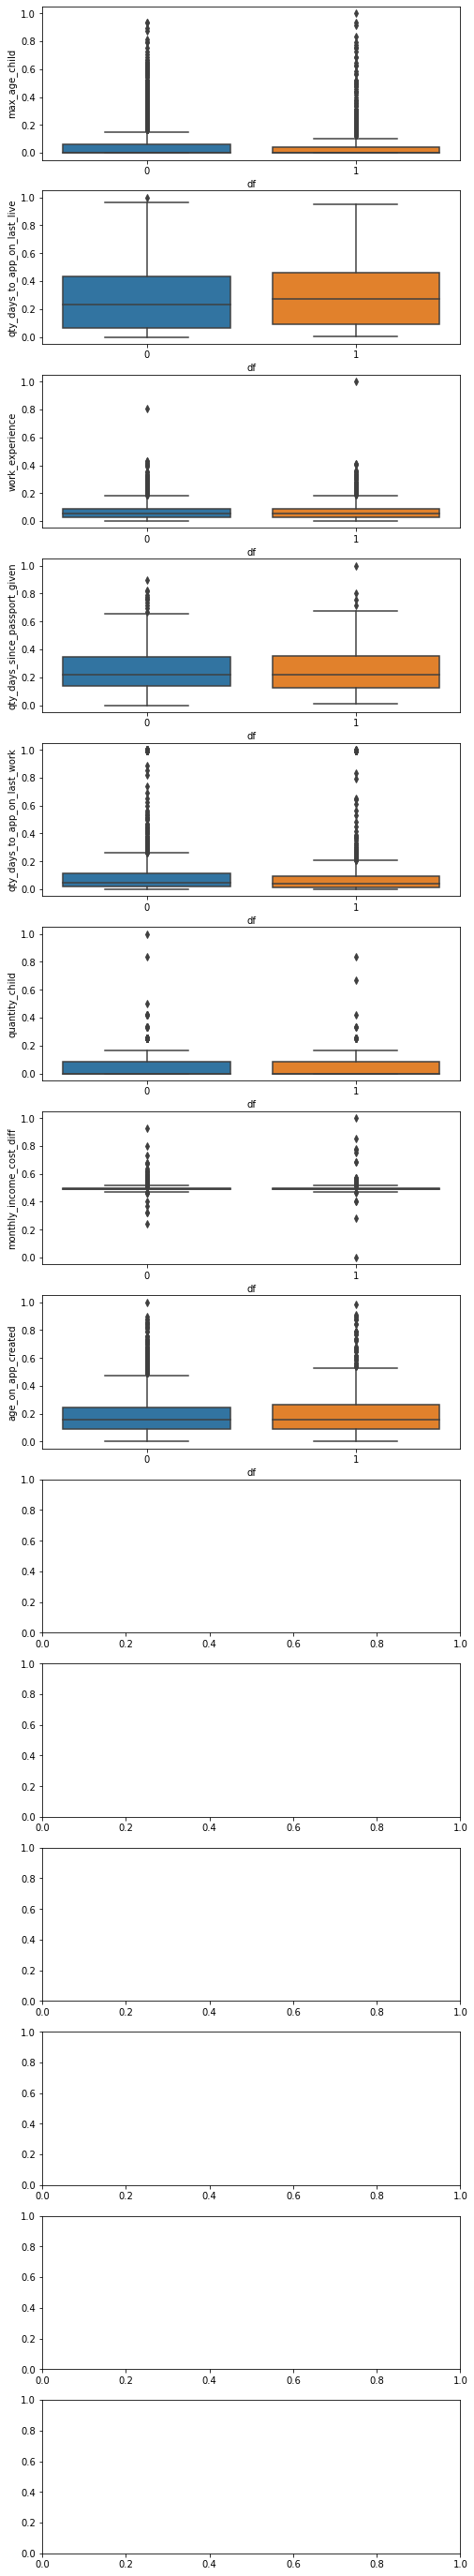

In [157]:
fig, axs = plt.subplots(nrows=len(numeric_features), figsize=(8, 50))

for index, feature in enumerate(appl_data_numeric_features):
    sns.boxplot(x=train_data['df'], y=train_data[feature], ax=axs[index]);

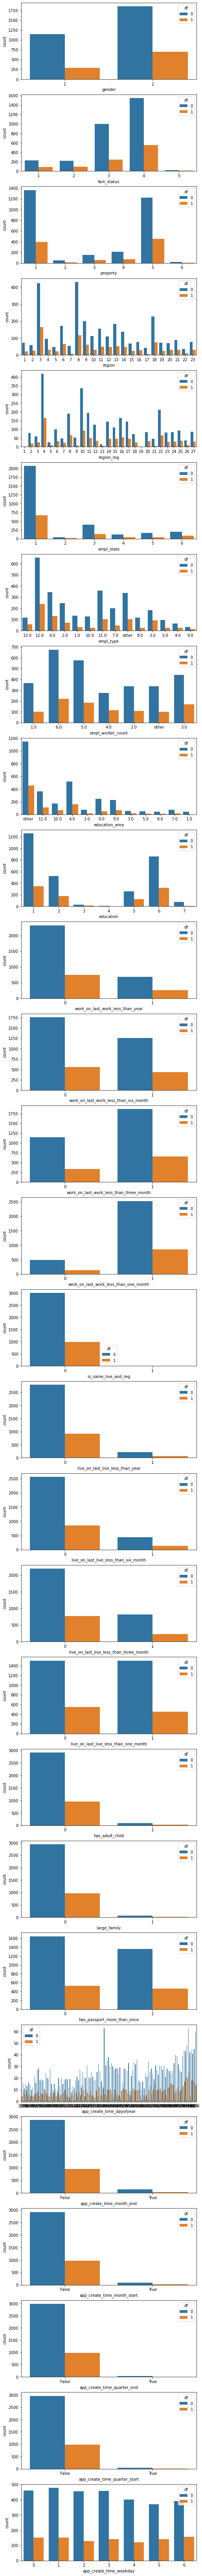

In [161]:
fig, axs = plt.subplots(nrows=len(categorical_features), figsize=(8, 120))

for index, feature in enumerate(categorical_features):
    sns.countplot(hue=train_data['df'], x=train_data[feature], ax=axs[index]);

In [162]:
train_data.groupby('gender').df.value_counts(normalize=True)

gender  df
1       0     0.797091
        1     0.202909
2       0     0.726740
        1     0.273260
Name: df, dtype: float64

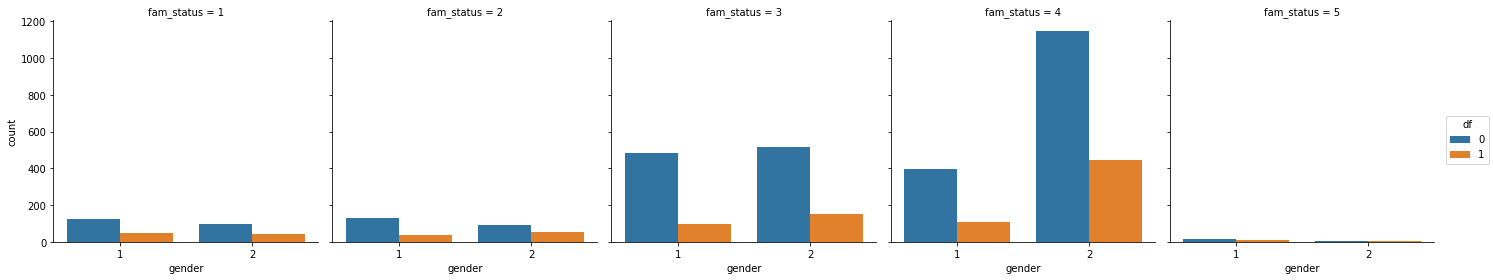

In [163]:
sns.factorplot(x='gender', col='fam_status', hue='df', data=train_data, kind='count');

In [164]:
train_data['work_on_last_work_less_than_year'].value_counts(normalize=True)

0    0.765117
1    0.234883
Name: work_on_last_work_less_than_year, dtype: float64

In [165]:
train_data['work_on_last_work_less_than_six_month'].value_counts(normalize=True)

0    0.577461
1    0.422539
Name: work_on_last_work_less_than_six_month, dtype: float64

In [166]:
train_data['work_on_last_work_less_than_three_month'].value_counts(normalize=True)

1    0.630185
0    0.369815
Name: work_on_last_work_less_than_three_month, dtype: float64

In [167]:
train_data['work_on_last_work_less_than_one_month'].value_counts(normalize=True)

1    0.845577
0    0.154423
Name: work_on_last_work_less_than_one_month, dtype: float64

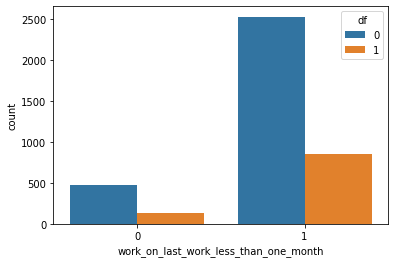

In [168]:
sns.countplot('work_on_last_work_less_than_one_month', data=train_data, hue='df');

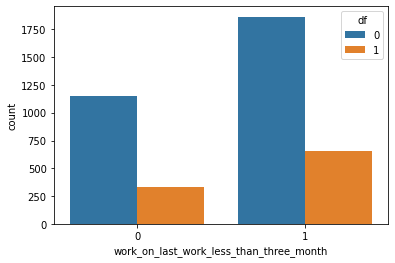

In [169]:
sns.countplot('work_on_last_work_less_than_three_month', data=train_data, hue='df');

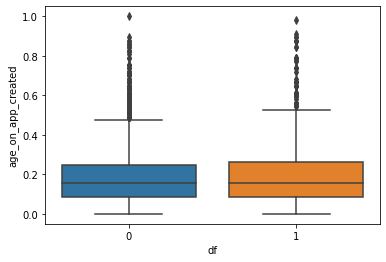

In [170]:
sns.boxplot(x='df', y='age_on_app_created', data=train_data)

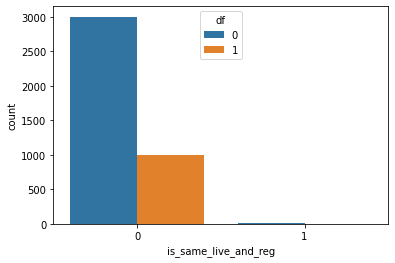

In [171]:
sns.countplot(x='is_same_live_and_reg', hue='df', data=train_data);

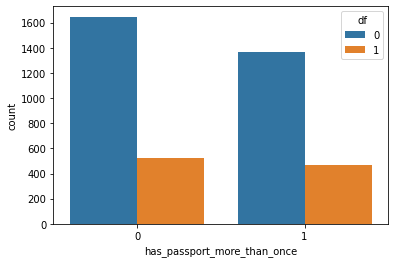

In [172]:
sns.countplot(x='has_passport_more_than_once', hue='df', data=train_data);

In [173]:
train_data.groupby('has_passport_more_than_once').df.value_counts(normalize=True)

has_passport_more_than_once  df
0                            0     0.757827
                             1     0.242173
1                            0     0.745355
                             1     0.254645
Name: df, dtype: float64

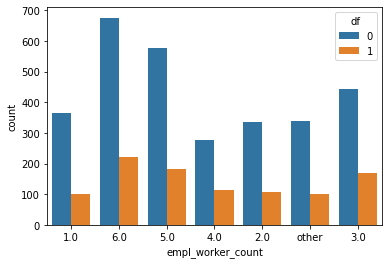

In [174]:
sns.countplot(x='empl_worker_count', hue='df', data=train_data);

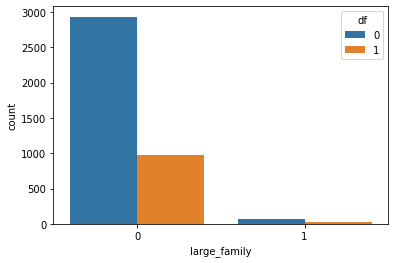

In [175]:
sns.countplot(x='large_family', hue='df', data=train_data);

In [176]:
train_data.groupby('large_family').df.value_counts(normalize=True)

large_family  df
0             0     0.751152
              1     0.248848
1             0     0.791667
              1     0.208333
Name: df, dtype: float64

In [178]:
feature_selector = fs.FeatureSelector(prepared_data_encoded[all_features_encoded],
                                     prepared_data_encoded['df'])

In [180]:
feature_selector.identify_missing(missing_threshold=0.7)

0 features with greater than 0.70 missing values.



In [181]:
feature_selector.identify_single_unique()

0 features with a single unique value.



In [182]:
feature_selector.identify_collinear(0.8)

3 features with a correlation magnitude greater than 0.80.



In [184]:
feature_selector.identify_zero_importance(task='classification', early_stopping=False)

Training Gradient Boosting Model


2 features with zero importance after one-hot encoding.



In [185]:
features_to_drop = feature_selector.ops['collinear'] + feature_selector.ops['zero_importance']

In [186]:
features_to_drop

['region_reg_encoded',
 'age_on_app_created',
 'qty_days_to_app_on_last_live',
 'qty_devices_used',
 'is_same_live_and_reg_encoded']